### Meta

In [1]:
# Autoreload modules without having to restart the notebook kernel.
# hi bilbo
%load_ext autoreload
%autoreload 2


# Plotting code stolen from Georg's notebook.
import matplotlib.pyplot as plt


%matplotlib inline
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 32}
plt.rc('font', **font)

### Imports

In [10]:
import sys
sys.path.insert(1, "..\\")


#import markov_clustering as mcl
import networkx as nx
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set_style(style = "white")
import copy
import numpy as np
import time
import re
import itertools


# Personal libraries
import lib.graph
import lib.files
import lib.centrality
import lib.map_names
#import lib.cluster
import lib.plot


In [3]:
# The first network is the largest connected component containing ICP55 with inviable proteins, has edges above 900 and no degree 0 nodes.
n0 = lib.graph.read_weighted_edgelist(lib.files.make_filepath_to_networks("icp55-cc-900-inv.txt"))

##Load in main network Julian O's df of key measures calculated on icp55 connected component, edge cutoff 900, keeping inviable proteins
network = lib.graph.read_weighted_edgelist(lib.files.make_filepath_to_networks('icp55-cc-900-inv.txt'))

master_df = pd.read_csv(lib.files.make_path_to_dataframes('icp55-cc-900-inv.mcl-2.5.nodes.dataframe.csv'), index_col=0, header=0)

##load in network with edge confidence recalcualted based on best evidence
network_bestevidence = lib.graph.read_weighted_edgelist(lib.files.make_filepath_to_networks('icp55-cc-900-inv-expbioch_coexp_curat_recalc.txt'))

In [ ]:
n0.edges()

## Validating bridging centrality

I want to know if bridging centrality does what we want it to - identify nodes that "bridge" clusters.

Methods:

Successively remove highest bridging centrality nodes in order, and see how it affects:

- Number of connected components
- Clustering coefficient (average)
- Mean shortest path between nodes
- Mean shortest path between clusters

In [37]:
#Load in Julian v's computed bridging centrality
df_bridge_sort = pd.read_csv(lib.files.path_to_tables("icp55-cc-900-inv-globalbridgingcentr.csv"), index_col = 0, header = 0)
df_bridge_sort["global_bridge_cent"] = df_bridge_sort["0"]
df_bridge_sort["protein"] = list(df_bridge_sort.index)\

#sort
df_bridge_sort = df_bridge_sort.sort_values(by = ["global_bridge_cent"],
              ascending = False)
print(df_bridge_sort.head())

                     0  global_bridge_cent       protein
4932.YGR149W  0.017724            0.017724  4932.YGR149W
4932.YHR181W  0.008014            0.008014  4932.YHR181W
4932.YJL225C  0.006480            0.006480  4932.YJL225C
4932.YJR150C  0.005430            0.005430  4932.YJR150C
4932.YBR056W  0.003020            0.003020  4932.YBR056W


#### Successive removal of highest bridging centrality nodes

This analysis mimics what is performed on Hwang et al. 2006

In [38]:
###NOTE: THIS CODE WILL TAKE SEVERAL HOURS (computation of clustering coefficient is costly). YOU CAN JUST LOAD THE COMPUTED DATA IN THE CHUNK BELOW

#Make data frame to store sequential removal stats
removal_stats_df = pd.DataFrame({"protein_removed": df_bridge_sort["protein"],
                                "bridging_centrality_removed": df_bridge_sort["global_bridge_cent"],
                                "num_nodes_removed": range(len(df_bridge_sort.index) +1)[1:]})

#Sequential remove
removed_network = copy.deepcopy(network)
num_CC = []
num_singletons = []
avg_clust_coeff = []
start = time.time()
for i in range(len(removal_stats_df.index)):
#for i in range(2):
    #removed_network = network.subgraph(list(removal_stats_df.iloc[(i + 1):, removal_stats_df.columns.get_loc("protein_removed")]))
    removed_network.remove_node(removal_stats_df.iloc[i, removal_stats_df.columns.get_loc("protein_removed")])
    
    #Number of connected components
    num_CC.append(nx.number_connected_components(removed_network))
    
    #Number of singletons
    num_singletons.append(sum(np.array(list(degree for (node, degree) in removed_network.degree())) == 0))
    
    #Avg. clustering coefficient
    avg_clust_coeff.append(nx.average_clustering(removed_network))
    
end = time.time()
print(end - start)    
    
removal_stats_df["num_CC"] = num_CC
removal_stats_df["avg_clust_coeff"] = avg_clust_coeff
removal_stats_df["num_singletons"] = num_singletons



removal_stats_df.to_csv("..\\data/tables/icp55-cc-900-inv-seq_remove_bridging.csv")

ZeroDivisionError: division by zero

Text(0, 0.5, 'Avg. clustering coefficient')

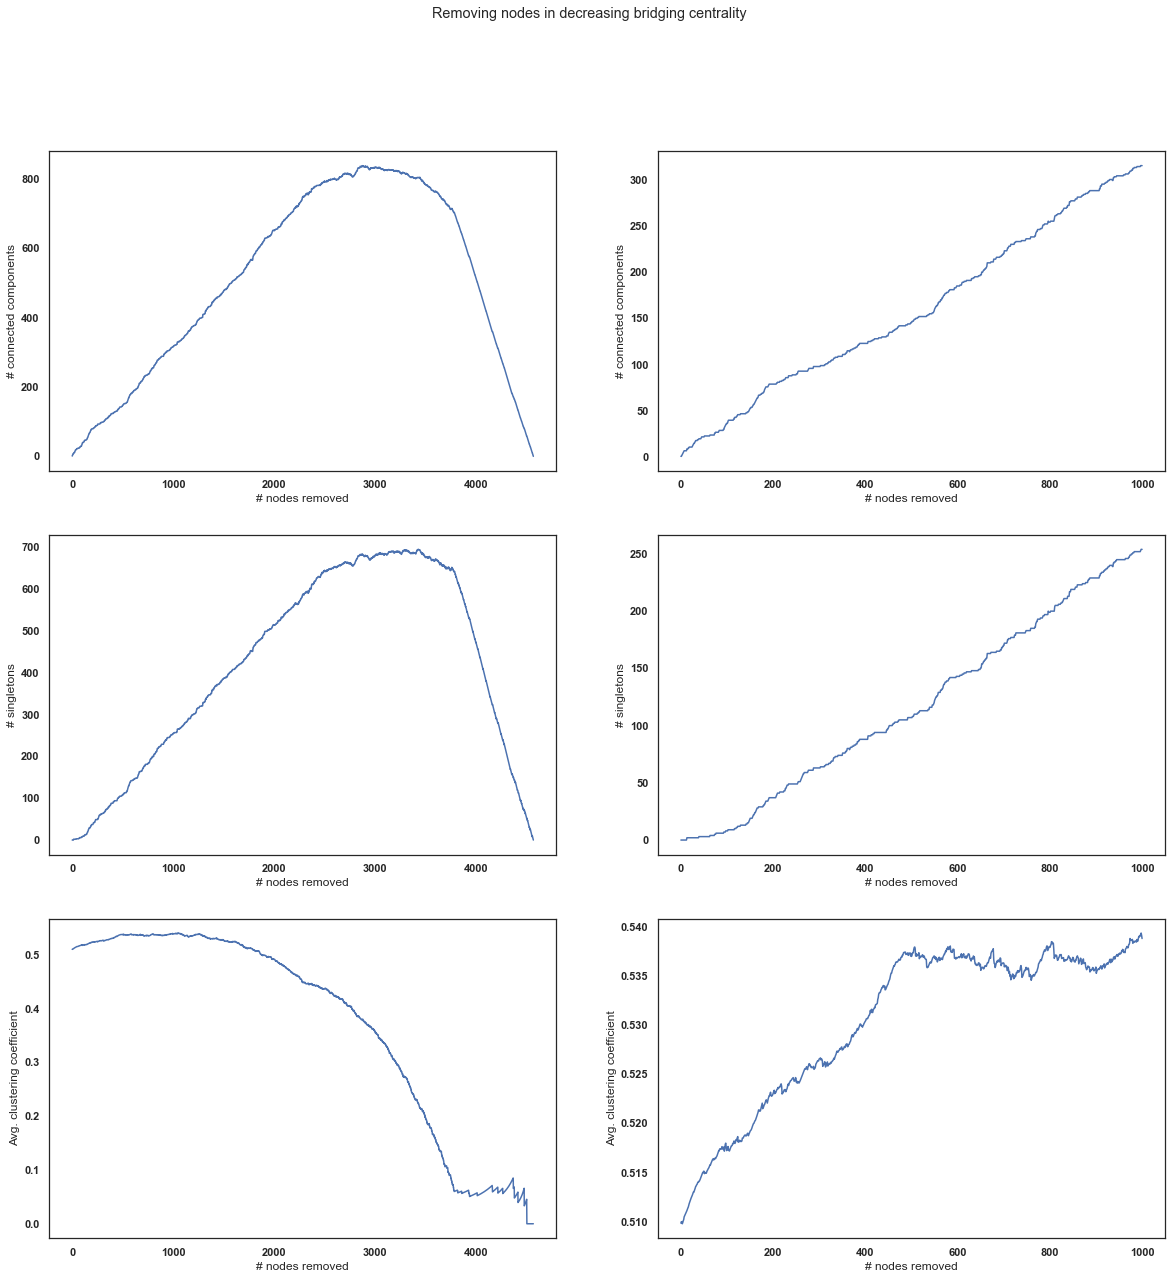

In [99]:
#Load in data if needed
#removal_stats_df = pd.read_csv("..\\data/tables/icp55-cc-900-inv-seq_remove_bridging.csv")

#Plot
fig, axes = plt.subplots(3, 2, figsize = (20, 20))
fig.suptitle("Removing nodes in decreasing bridging centrality")

sns.lineplot(data = removal_stats_df,
         x = "num_nodes_removed",
                   y = "num_CC",
            ax = axes[0, 0])
axes[0, 0].set_xlabel("# nodes removed")
axes[0, 0].set_ylabel("# connected components")

sns.lineplot(data = removal_stats_df,
         x = "num_nodes_removed",
                   y = "num_singletons",
            ax = axes[1, 0])
axes[1, 0].set_xlabel("# nodes removed")
axes[1, 0].set_ylabel("# singletons")

sns.lineplot(data = removal_stats_df,
         x = "num_nodes_removed",
                   y = "avg_clust_coeff",
            ax = axes[2, 0])
axes[2, 0].set_xlabel("# nodes removed")
axes[2, 0].set_ylabel("Avg. clustering coefficient")

sns.lineplot(data = removal_stats_df.iloc[0:999, ],
         x = "num_nodes_removed",
                   y = "num_CC",
            ax = axes[0, 1])
axes[0, 1].set_xlabel("# nodes removed")
axes[0, 1].set_ylabel("# connected components")

sns.lineplot(data = removal_stats_df.iloc[0:999, ],
         x = "num_nodes_removed",
                   y = "num_singletons",
            ax = axes[1, 1])
axes[1, 1].set_xlabel("# nodes removed")
axes[1, 1].set_ylabel("# singletons")

sns.lineplot(data = removal_stats_df.iloc[0:999, ],
         x = "num_nodes_removed",
                   y = "avg_clust_coeff",
            ax = axes[2, 1])
axes[2, 1].set_xlabel("# nodes removed")
axes[2, 1].set_ylabel("Avg. clustering coefficient")



The right column shows only the removal of the top 1000 bridging nodes. I think this is more informative.

We see that as bridging nodes are removed, the number of connected components increases, indicating the network becomes fractured. Initially (for the first ~180 nodes) there is only minimal increase in the number of singletons, suggesting this fracturing is not characterised by disconnecting single nodes.

Clustering coefficient increases steadily over the first 1000 nodes, suggesting the network is become more clustered (as we would expect). It then decreases past the first 1000 nodes.

#### Are bridging nodes in clusters?

Ideally, bridging nodes should be positioned between clusters, not within them. I test that here.

In [102]:
###Plot bridging centrality and cluster size

#Remove the 3 very high outliers
sns.relplot(data = df_bridge_sort,
           x = "global_bridge_cent",
           y = "cluster_size")


#Plot between quantiles
##THIS IS NOT REALLY WORKING - MAYBE BECAUSE THEY ARE VERY SMALL VALUES?
num_quantiles = 4
for i in range(num_quantiles):
    
    upper_quant = df_bridge_sort["global_bridge_cent"].quantile((i + 1)/num_quantiles)
    lower_quant = df_bridge_sort["global_bridge_cent"].quantile((i)/num_quantiles)
    print(lower_quant)
    print(upper_quant)
    print(len(df_bridge_sort.loc[(df_bridge_sort["global_bridge_cent"] <= upper_quant) & (df_bridge_sort["global_bridge_cent"] > lower_quant), ].index))
    
    sns.relplot(data = df_bridge_sort.loc[(df_bridge_sort["global_bridge_cent"] <= upper_quant) & (df_bridge_sort["global_bridge_cent"] > lower_quant), ],
           x = "global_bridge_cent",
           y = "cluster_size")

ValueError: Could not interpret value `cluster_size` for parameter `y`

So there is a trend for higher bridging centrality nodes to be in smaller clusters. But it is certainly just a trend.

## Exploring clusters related to ICP55 and PIM1

### Explore network of ICP55 and PIM1 2nd shell neighbours and clusters

In [165]:
###Function: concatenate a list of proteins
def protein_concatenator(protein_list):
    
    if len(protein_list) == 0:
        return("")
    
    else:    
        for i in range(len(protein_list)):
            if i == 0:
                concatenated = str(protein_list[i])
            else:
                concatenated = str(concatenated) + ";" + str(protein_list[i])

        return(concatenated)

In [172]:
###Criteria:
#Cluster has one node path length 2 or less from icp55/pim1
#Cluster size >= 5
clusters_pl2away = list(dict.fromkeys(master_df[((master_df["icp55_shell"] <= 2) | 
                                                 (master_df["pim1_shell"] <= 2)) &
                                                (master_df["cluster_size"] >= 5)]["cluster_id"]))

###Make cluster summary df
clusters_pl2away_df = pd.DataFrame({"cluster_id": clusters_pl2away})
clusters_pl2away_df["cluster_size"] = 0
clusters_pl2away_df["3mostcentral_closeness_proteins"] = ""
clusters_pl2away_df["3mostcentral_closeness_genes"] = ""
clusters_pl2away_df["3mostcentral_closeness_descriptions"] = ""
clusters_pl2away_df["3mostcentral_eigenvector_proteins"] = ""
clusters_pl2away_df["3mostcentral_eigenvector_genes"] = ""
clusters_pl2away_df["3mostcentral_eigenvector_descriptions"] = ""
clusters_pl2away_df["icp55_pl2away_proteins"] = ""
clusters_pl2away_df["pim1_pl2away_proteins"] = ""
clusters_pl2away_df["icp55_shortest_paths_maxmin_bestevidence"] = 0
clusters_pl2away_df["pim1_shortest_paths_maxmin_bestevidence"] = 0


###Add size, and top three most central proteins (by cluster eigenvector and closeness)
for i in range(len(clusters_pl2away_df.index)):
    cluster_id = clusters_pl2away_df.iloc[i, 0]
    
    #Df of all in cluster
    cluster_df = master_df[master_df["cluster_id"]  == cluster_id]
    
    #Assign cluster size
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("cluster_size")] = list(cluster_df["cluster_size"])[0]
    
    #Assign top 3 closeness nodes
    top_closeness_proteins = list(cluster_df.sort_values(by = ["cluster_closeness"],
                                                                       ascending = False).iloc[0:3, master_df.columns.get_loc("protein")])
    top_closeness_genes = lib.map_names.map_names_descriptions(names = top_closeness_proteins,
                                                                name_type = "systematic_name_nonumber",
                                                                output = "gene_name")
    top_closeness_descriptions = lib.map_names.map_names_descriptions(names = top_closeness_proteins,
                                                                name_type = "systematic_name_nonumber",
                                                                output = "description")
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_closeness_proteins")] = protein_concatenator(top_closeness_proteins)
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_closeness_genes")] = protein_concatenator(top_closeness_genes)
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_closeness_descriptions")] = protein_concatenator(top_closeness_descriptions)
    #Assign top 3 eigenvector nodes
    top_eigenvector_proteins = list(cluster_df.sort_values(by = ["cluster_eigenvector"],
                                                                       ascending = False).iloc[0:3, master_df.columns.get_loc("protein")])
    top_eigenvector_genes = lib.map_names.map_names_descriptions(names = top_eigenvector_proteins,
                                                                name_type = "systematic_name_nonumber",
                                                                output = "gene_name")
    top_eigenvector_descriptions = lib.map_names.map_names_descriptions(names = top_eigenvector_proteins,
                                                                name_type = "systematic_name_nonumber",
                                                                output = "description")
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_eigenvector_proteins")] = protein_concatenator(top_eigenvector_proteins)
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_eigenvector_genes")] = protein_concatenator(top_eigenvector_genes)
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_eigenvector_descriptions")] = protein_concatenator(top_eigenvector_descriptions)
    
    #Get the specific proteins within path length 2 of icp55 or pim1
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("icp55_pl2away_proteins")] = protein_concatenator(list(cluster_df[cluster_df["icp55_shell"] <= 2]["protein"]))
    #Get the specific proteins within path length 2 of icp55 or pim1
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("pim1_pl2away_proteins")] = protein_concatenator(list(cluster_df[cluster_df["pim1_shell"] <= 2]["protein"]))
    
    #For each shortest path from icp55/pim1 to the cluster, take the minimum bestevidence score, then take max across shortest paths
    minmax_bestevidence = lib.graph.closest_clusters_minmax_pathweights('icp55-cc-900-inv', 
                                         'mcl-2.5', 
                                         master_df_name = '..\\data/tables/icp55-cc-900-inv.mcl-2.5.nodes.dataframe.csv',
                                         cluster_id = cluster_id, 
                                         shorp_threshold = 2,
                                             edge_network = network_bestevidence) 
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("icp55_shortest_paths_maxmin_bestevidence")] = minmax_bestevidence[0]
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("pim1_shortest_paths_maxmin_bestevidence")] = minmax_bestevidence[1]
    
clusters_pl2away_df["max_shortest_paths_maxmin_bestevidence"] = clusters_pl2away_df[["icp55_shortest_paths_maxmin_bestevidence", 
                    "pim1_shortest_paths_maxmin_bestevidence"]].apply(max, 1)
###Output
clusters_pl2away_df.to_csv("..\\data/tables/icp55-cc-900-inv.mcl-2.5.icp55pim1pl2.clusters.csv")

#### Save images of close clusters + shortest paths linking to icp55 and pim1, and output as .txt for input into STRING. Also get path info

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

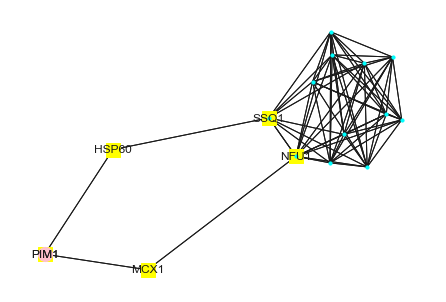

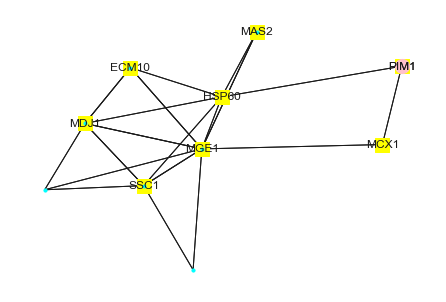

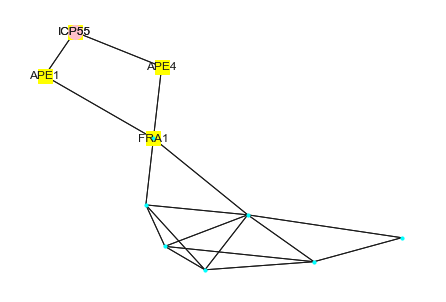

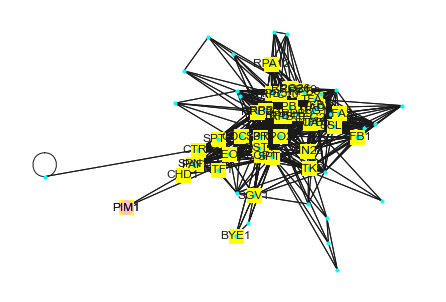

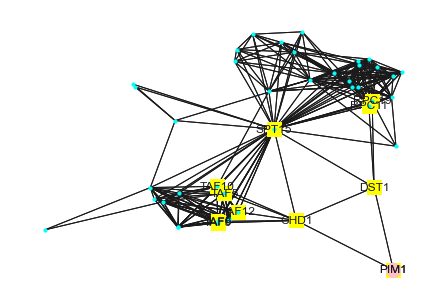

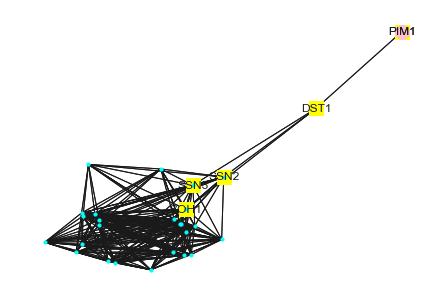

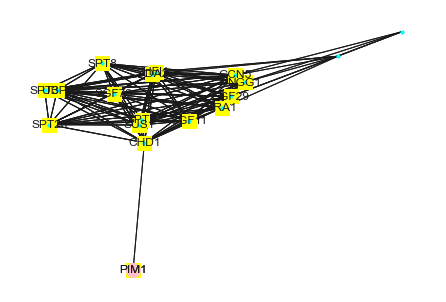

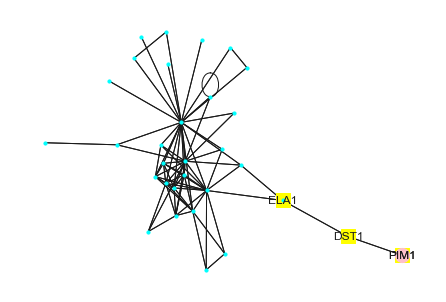

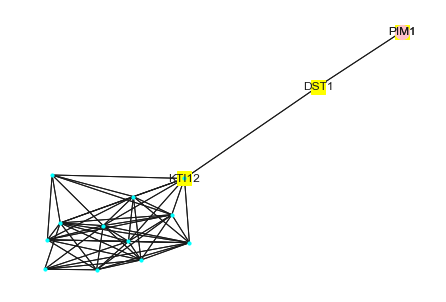

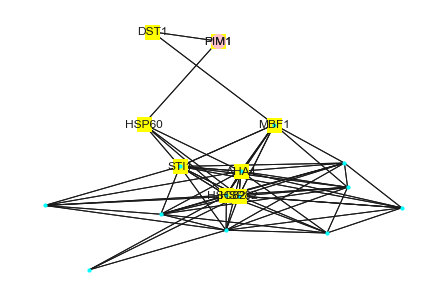

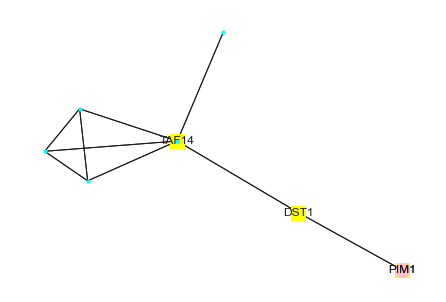

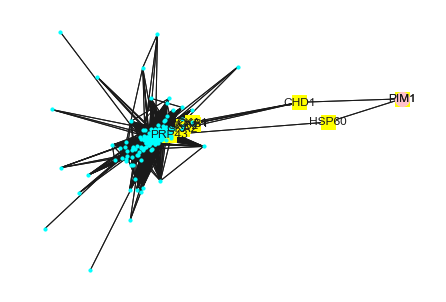

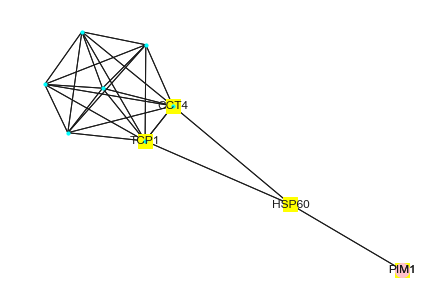

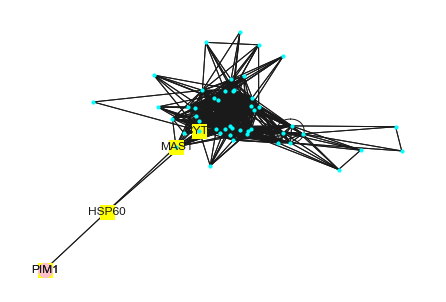

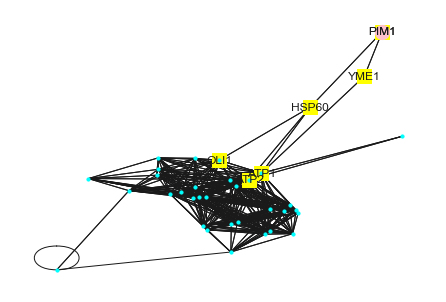

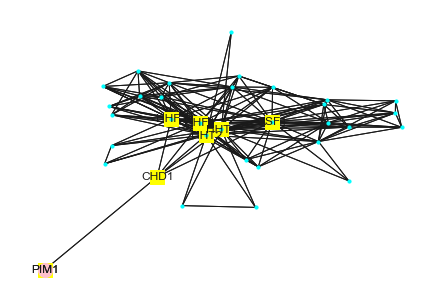

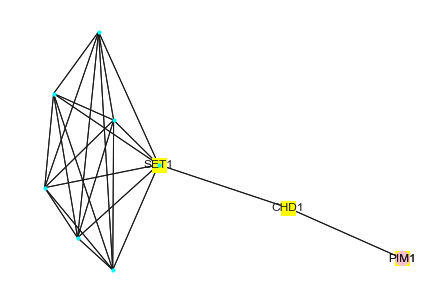

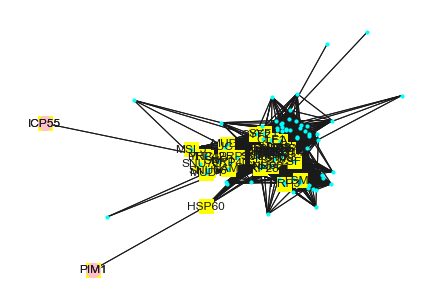

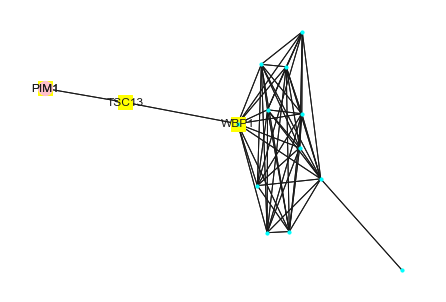

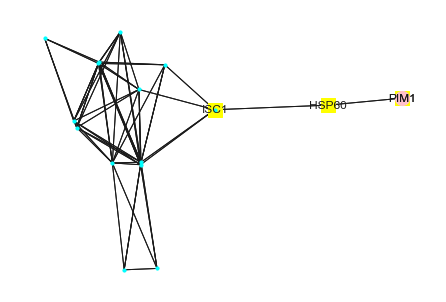

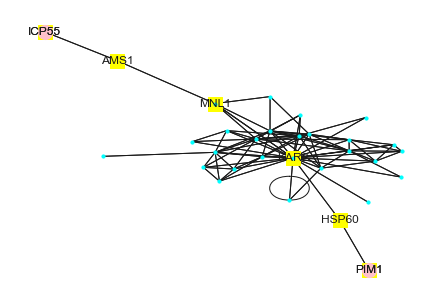

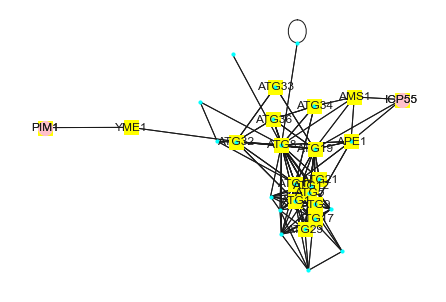

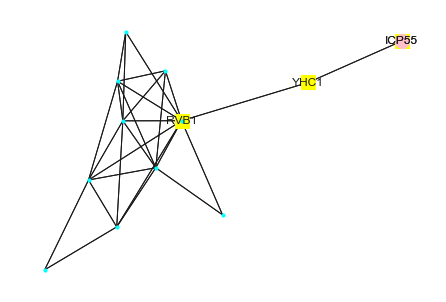

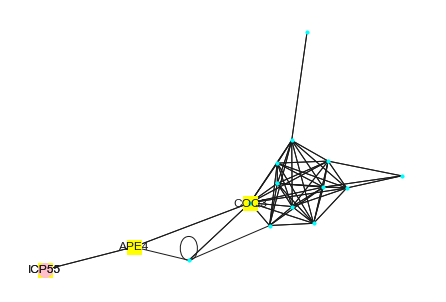

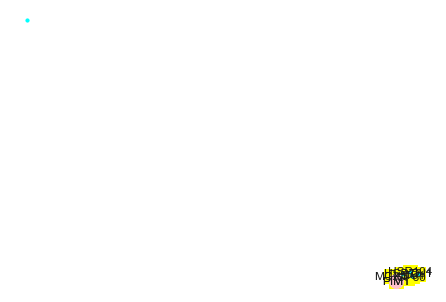

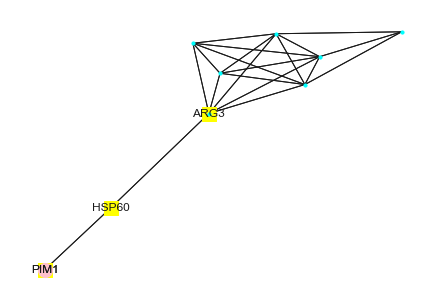

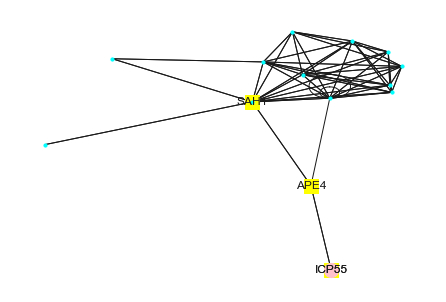

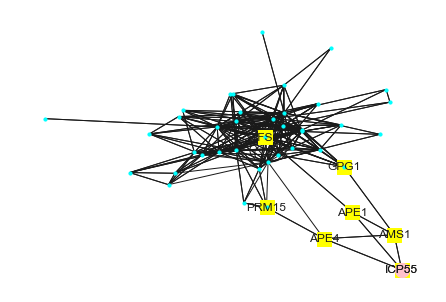

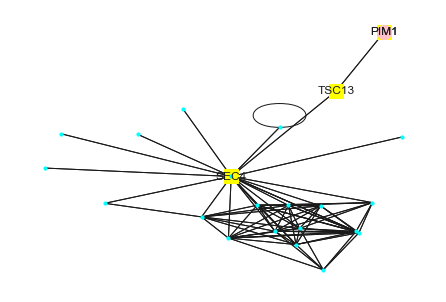

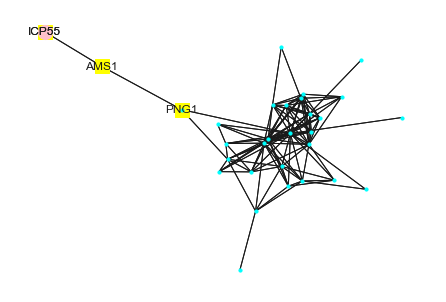

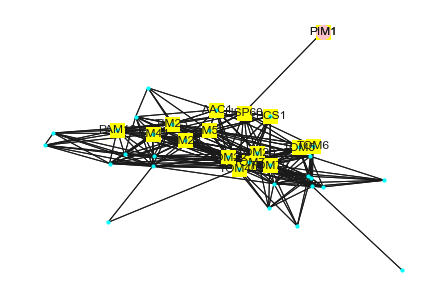

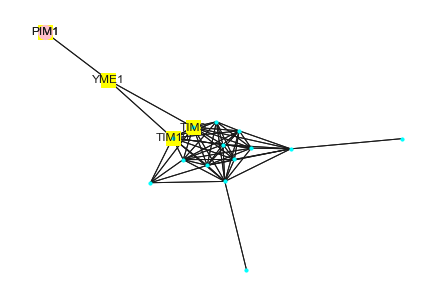

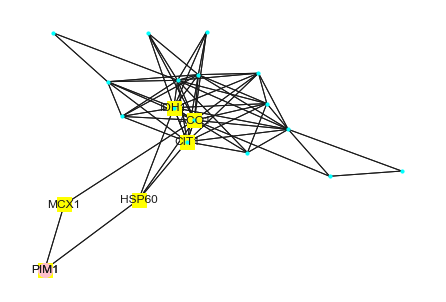

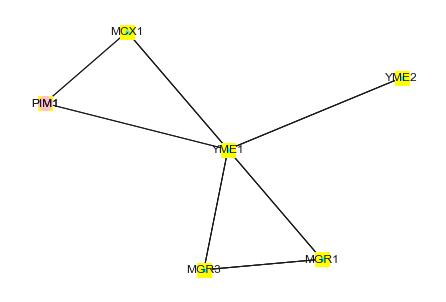

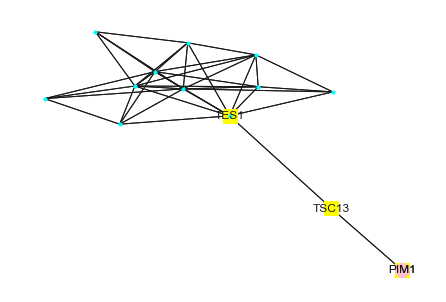

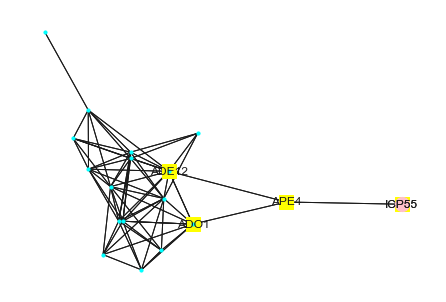

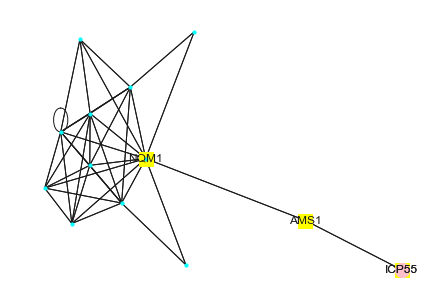

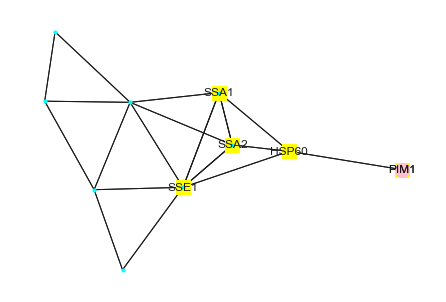

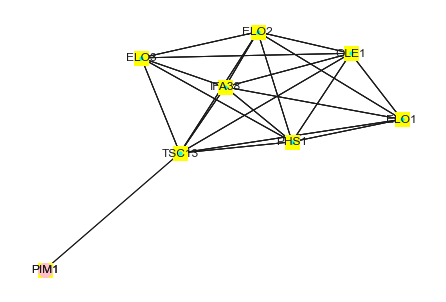

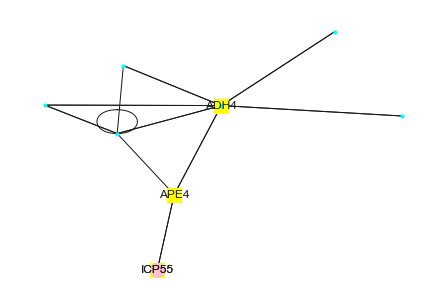

In [55]:
for cluster_id in list(clusters_pl2away_df["cluster_id"]):
    lib.plot.closest_clusters_with_paths_vis('icp55-cc-900-inv', 
                                         'mcl-2.5', 
                                         master_df_name = '..\\data/tables/icp55-cc-900-inv.mcl-2.5.nodes.dataframe.csv',
                                         cluster_id = cluster_id, 
                                         shorp_threshold = 2, ax=None, top_size=200, target_size=200,
                                        save = True) 
    
    lib.graph.closest_clusters_path_info('icp55-cc-900-inv', 
                                         'mcl-2.5', 
                                         master_df_name = '..\\data/tables/icp55-cc-900-inv.mcl-2.5.nodes.dataframe.csv',
                                         cluster_id = cluster_id, 
                                         shorp_threshold = 2,
                                             edge_network = network_bestevidence).to_csv("..\\data/cluster_validation/clusters_and_shorps/cluster" + str(cluster_id) + "shorps_info.csv",
                                                                                        index = False)

## Assessing different channels of evidence
Here I load the STRING network that is expanded to show channels of evidence (e.g. biochemical evidence of interaction, comentioning in abstracts, etc.)

#### Making networks for different channels of evidence
I include adding together ExperimentalBiochemical_Data, Association_in_Curated_Databases, and Co-Mentioned_in_Pubmed_Abstracts

In [97]:
###Load in data
string_channels_raw = pd.read_csv("..\\data/4932.protein.links.detailed.v11.5.txt",
                                 sep = " ",
                                 header = None)

#Full
#string_channels_full = pd.read_csv("..\\data/4932.protein.links.full.v11.5.txt",
#                                 sep = " ",
#                                 header = None)

In [118]:
####Process detailed

###Change column names
string_channels_raw = string_channels_raw.set_axis(["node1", 
                                  "node2",
                                 "Neighborhood_in_the_Genome",
                                 "Gene_Fusions",
                                 "Cooccurence_Across_Genomes",
                                 "Co-Expression",
                                 "ExperimentalBiochemical_Data",
                                 "Association_in_Curated_Databases",
                                 "Co-Mentioned_in_Pubmed_Abstracts",
                             "Combined_Score"],
                            axis = 1)

###Add expbioch_coexp_curat
string_channels_raw["expbioch_coexp_curat"] = string_channels_raw["Co-Expression"] + string_channels_raw["ExperimentalBiochemical_Data"] + string_channels_raw["Association_in_Curated_Databases"]

###Export individually
columns = ["Neighborhood_in_the_Genome",
                                 "Gene_Fusions",
                                 "Cooccurence_Across_Genomes",
                                 "Co-Expression",
                                 "ExperimentalBiochemical_Data",
                                 "Association_in_Curated_Databases",
                                 "Co-Mentioned_in_Pubmed_Abstracts",
                                 "Combined_Score",
                                  "expbioch_coexp_curat"]

for column in columns:
    string_specific_channel = string_channels_raw[["node1", "node2", column]]
    string_specific_channel.to_csv("..\\data/4932.protein.links.detailed.v11.5." + column + ".txt",
                                  header = False,
                                  index = False,
                                  sep = " ")

In [100]:
####Process full
string_channels_full = string_channels_full.set_axis(["node1", 
                                  "node2",
                                  "neighborhood",
                                "neighborhood_transferred",
     "fusion", "cooccurrence",
     "homology",
     "coexpression", "coexpression_transferred",
     "experiments", "experiments_transferred",
     "database", "database_transferred",
     "textmining", "textmining_transferred",
     "initial_combined"],
                            axis = 1)

columns = ["coexpression",
          "coexpression_transferred",
          "experiments",
          "experiments_transferred",
          "database",
          "database_transferred"]

for column in columns:
    string_specific_channel = string_channels_full[["node1", "node2", column]]
    string_specific_channel.to_csv("..\\data/4932.protein.links.full.v11.5." + column + ".txt",
                                  header = False,
                                  index = False,
                                  sep = " ")

### Combining scores

#### Implementing on the network itself

I calculate this using the networkx graph object, that is connected component of icp55 with edge confidence 900 threshold.
This is very fast (yay!)
The result is a new graph, with is data/networks/icp55-cc-900-inv-expbioch_coexp_curat_recalc 

In [102]:
##Load in
string_exp = nx.read_weighted_edgelist("..\\data/4932.protein.links.full.v11.5.experiments.txt")
string_exp_trans = nx.read_weighted_edgelist("..\\data/4932.protein.links.full.v11.5.experiments_transferred.txt")
string_database = nx.read_weighted_edgelist("..\\data/4932.protein.links.full.v11.5.database.txt")
string_database_trans = nx.read_weighted_edgelist("..\\data/4932.protein.links.full.v11.5.database_transferred.txt")
string_coexpression = nx.read_weighted_edgelist("..\\data/4932.protein.links.full.v11.5.coexpression.txt")
string_coexpression_trans = nx.read_weighted_edgelist("..\\data/4932.protein.links.full.v11.5.coexpression_transferred.txt")

In [105]:
##Perform computation just on relevant network
network_expbioch_coexp_curat_recalc = copy.deepcopy(network)
print(len(network_expbioch_coexp_curat_recalc.edges()))

##Remove prior function
prior = 0.041

def compute_prior_away(score, prior):

    if score < prior: score = prior
    score_no_prior = (score - prior) / (1 - prior)

    return score_no_prior

##Compute
for edge in network_expbioch_coexp_curat_recalc.edges():
    protein1 = "4932." + edge[0]
    protein2 = "4932." + edge[1]
    
    #Remove prior
    string_exp_noprior = compute_prior_away(float(string_exp[protein1][protein2]["weight"])/1000, prior)
    string_exp_trans_noprior = compute_prior_away(float(string_exp_trans[protein1][protein2]["weight"])/1000, prior)
    string_database_noprior = compute_prior_away(float(string_database[protein1][protein2]["weight"])/1000, prior)
    string_database_trans_noprior = compute_prior_away(float(string_database_trans[protein1][protein2]["weight"])/1000, prior)
    string_coexpression_noprior = compute_prior_away(float(string_coexpression[protein1][protein2]["weight"])/1000, prior)
    string_coexpression_trans_noprior = compute_prior_away(float(string_coexpression_trans[protein1][protein2]["weight"])/1000, prior)
    
    #Combine direct and transferred
    string_exp_both_noprior = 1 - (1 - string_exp_noprior)*(1 - string_exp_trans_noprior)
    string_database_both_noprior = 1 - (1 - string_database_noprior)*(1 - string_database_trans_noprior)
    string_coexpression_both_noprior = 1 - (1 - string_coexpression_noprior)*(1 - string_coexpression_trans_noprior)
    
    #Combine
    comb_noprior = 1 - (1 - string_exp_both_noprior)*(1 - string_database_both_noprior)*(1 - string_coexpression_both_noprior)
    
    #Prior back in
    comb_wprior = comb_noprior*(1.0 - prior) + prior
    
    #Assign
    network_expbioch_coexp_curat_recalc[edge[0]][edge[1]]["weight"] = int(1000*comb_wprior)
    
#Export
nx.write_weighted_edgelist(network_expbioch_coexp_curat_recalc, "..\\data/networks/icp55-cc-900-inv-expbioch_coexp_curat_recalc.txt")

61515
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715


5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894


8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384
8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400


11200
11201
11202
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
11266
11267
11268
11269
11270
11271
11272
11273
11274
11275
11276
11277
11278
11279
11280
11281
11282
11283
11284
11285
11286
11287
11288
11289
11290
11291
11292
11293
11294
11295
11296
11297
11298
11299
11300
11301
11302
11303
11304
11305
11306
11307
11308
11309
11310
11311
11312
11313
11314
11315
11316
11317
11318
11319
11320
11321
11322
11323
11324
11325
11326
11327
11328
11329
11330
11331
11332
11333
11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
11348
11349
11350
11351
11352
11353
11354
11355
11356
11357
11358
11359
11360
11361
11362
11363
11364
11365
1136

12700
12701
12702
12703
12704
12705
12706
12707
12708
12709
12710
12711
12712
12713
12714
12715
12716
12717
12718
12719
12720
12721
12722
12723
12724
12725
12726
12727
12728
12729
12730
12731
12732
12733
12734
12735
12736
12737
12738
12739
12740
12741
12742
12743
12744
12745
12746
12747
12748
12749
12750
12751
12752
12753
12754
12755
12756
12757
12758
12759
12760
12761
12762
12763
12764
12765
12766
12767
12768
12769
12770
12771
12772
12773
12774
12775
12776
12777
12778
12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
1286

14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
1436

15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
15803
15804
15805
15806
15807
15808
15809
15810
15811
15812
15813
15814
15815
15816
15817
15818
15819
15820
15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
15861
15862
15863
1586

17305
17306
17307
17308
17309
17310
17311
17312
17313
17314
17315
17316
17317
17318
17319
17320
17321
17322
17323
17324
17325
17326
17327
17328
17329
17330
17331
17332
17333
17334
17335
17336
17337
17338
17339
17340
17341
17342
17343
17344
17345
17346
17347
17348
17349
17350
17351
17352
17353
17354
17355
17356
17357
17358
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368
17369
17370
17371
17372
17373
17374
17375
17376
17377
17378
17379
17380
17381
17382
17383
17384
17385
17386
17387
17388
17389
17390
17391
17392
17393
17394
17395
17396
17397
17398
17399
17400
17401
17402
17403
17404
17405
17406
17407
17408
17409
17410
17411
17412
17413
17414
17415
17416
17417
17418
17419
17420
17421
17422
17423
17424
17425
17426
17427
17428
17429
17430
17431
17432
17433
17434
17435
17436
17437
17438
17439
17440
17441
17442
17443
17444
17445
17446
17447
17448
17449
17450
17451
17452
17453
17454
17455
17456
17457
17458
17459
17460
17461
17462
17463
17464
17465
17466
17467
17468
17469
17470
1747

18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
18978
18979
18980
18981
18982
18983
18984
18985
18986
18987
18988
18989
18990
18991
18992
18993
18994
18995
18996
18997
18998
18999
19000
19001
19002
19003
19004
19005
19006
19007
19008
19009
19010
19011
19012
19013
19014
19015
19016
19017
19018
19019
19020
19021
19022
19023
19024
19025
19026
19027
19028
19029
19030
19031
19032
19033
19034
19035
19036
19037
19038
19039
19040
19041
19042
19043
19044
19045
19046
19047
19048
19049
19050
19051
19052
19053
19054
19055
19056
19057
19058
19059
19060
19061
19062
19063
19064
19065
19066
19067
19068
19069
19070
19071
19072
19073
19074
19075
19076
19077
19078
19079
19080
19081
19082
19083
19084
19085
19086
19087
19088
19089
19090
19091
19092
19093
19094
19095
19096
19097
19098
19099
19100
19101
19102
19103
19104
19105
19106
19107
19108
19109
19110
19111
19112
19113
19114
19115
19116
19117
19118
19119
19120
19121
19122
19123
19124
19125
19126
19127
1912

21524
21525
21526
21527
21528
21529
21530
21531
21532
21533
21534
21535
21536
21537
21538
21539
21540
21541
21542
21543
21544
21545
21546
21547
21548
21549
21550
21551
21552
21553
21554
21555
21556
21557
21558
21559
21560
21561
21562
21563
21564
21565
21566
21567
21568
21569
21570
21571
21572
21573
21574
21575
21576
21577
21578
21579
21580
21581
21582
21583
21584
21585
21586
21587
21588
21589
21590
21591
21592
21593
21594
21595
21596
21597
21598
21599
21600
21601
21602
21603
21604
21605
21606
21607
21608
21609
21610
21611
21612
21613
21614
21615
21616
21617
21618
21619
21620
21621
21622
21623
21624
21625
21626
21627
21628
21629
21630
21631
21632
21633
21634
21635
21636
21637
21638
21639
21640
21641
21642
21643
21644
21645
21646
21647
21648
21649
21650
21651
21652
21653
21654
21655
21656
21657
21658
21659
21660
21661
21662
21663
21664
21665
21666
21667
21668
21669
21670
21671
21672
21673
21674
21675
21676
21677
21678
21679
21680
21681
21682
21683
21684
21685
21686
21687
21688
21689
2169

23148
23149
23150
23151
23152
23153
23154
23155
23156
23157
23158
23159
23160
23161
23162
23163
23164
23165
23166
23167
23168
23169
23170
23171
23172
23173
23174
23175
23176
23177
23178
23179
23180
23181
23182
23183
23184
23185
23186
23187
23188
23189
23190
23191
23192
23193
23194
23195
23196
23197
23198
23199
23200
23201
23202
23203
23204
23205
23206
23207
23208
23209
23210
23211
23212
23213
23214
23215
23216
23217
23218
23219
23220
23221
23222
23223
23224
23225
23226
23227
23228
23229
23230
23231
23232
23233
23234
23235
23236
23237
23238
23239
23240
23241
23242
23243
23244
23245
23246
23247
23248
23249
23250
23251
23252
23253
23254
23255
23256
23257
23258
23259
23260
23261
23262
23263
23264
23265
23266
23267
23268
23269
23270
23271
23272
23273
23274
23275
23276
23277
23278
23279
23280
23281
23282
23283
23284
23285
23286
23287
23288
23289
23290
23291
23292
23293
23294
23295
23296
23297
23298
23299
23300
23301
23302
23303
23304
23305
23306
23307
23308
23309
23310
23311
23312
23313
2331

24679
24680
24681
24682
24683
24684
24685
24686
24687
24688
24689
24690
24691
24692
24693
24694
24695
24696
24697
24698
24699
24700
24701
24702
24703
24704
24705
24706
24707
24708
24709
24710
24711
24712
24713
24714
24715
24716
24717
24718
24719
24720
24721
24722
24723
24724
24725
24726
24727
24728
24729
24730
24731
24732
24733
24734
24735
24736
24737
24738
24739
24740
24741
24742
24743
24744
24745
24746
24747
24748
24749
24750
24751
24752
24753
24754
24755
24756
24757
24758
24759
24760
24761
24762
24763
24764
24765
24766
24767
24768
24769
24770
24771
24772
24773
24774
24775
24776
24777
24778
24779
24780
24781
24782
24783
24784
24785
24786
24787
24788
24789
24790
24791
24792
24793
24794
24795
24796
24797
24798
24799
24800
24801
24802
24803
24804
24805
24806
24807
24808
24809
24810
24811
24812
24813
24814
24815
24816
24817
24818
24819
24820
24821
24822
24823
24824
24825
24826
24827
24828
24829
24830
24831
24832
24833
24834
24835
24836
24837
24838
24839
24840
24841
24842
24843
24844
2484

26196
26197
26198
26199
26200
26201
26202
26203
26204
26205
26206
26207
26208
26209
26210
26211
26212
26213
26214
26215
26216
26217
26218
26219
26220
26221
26222
26223
26224
26225
26226
26227
26228
26229
26230
26231
26232
26233
26234
26235
26236
26237
26238
26239
26240
26241
26242
26243
26244
26245
26246
26247
26248
26249
26250
26251
26252
26253
26254
26255
26256
26257
26258
26259
26260
26261
26262
26263
26264
26265
26266
26267
26268
26269
26270
26271
26272
26273
26274
26275
26276
26277
26278
26279
26280
26281
26282
26283
26284
26285
26286
26287
26288
26289
26290
26291
26292
26293
26294
26295
26296
26297
26298
26299
26300
26301
26302
26303
26304
26305
26306
26307
26308
26309
26310
26311
26312
26313
26314
26315
26316
26317
26318
26319
26320
26321
26322
26323
26324
26325
26326
26327
26328
26329
26330
26331
26332
26333
26334
26335
26336
26337
26338
26339
26340
26341
26342
26343
26344
26345
26346
26347
26348
26349
26350
26351
26352
26353
26354
26355
26356
26357
26358
26359
26360
26361
2636

28137
28138
28139
28140
28141
28142
28143
28144
28145
28146
28147
28148
28149
28150
28151
28152
28153
28154
28155
28156
28157
28158
28159
28160
28161
28162
28163
28164
28165
28166
28167
28168
28169
28170
28171
28172
28173
28174
28175
28176
28177
28178
28179
28180
28181
28182
28183
28184
28185
28186
28187
28188
28189
28190
28191
28192
28193
28194
28195
28196
28197
28198
28199
28200
28201
28202
28203
28204
28205
28206
28207
28208
28209
28210
28211
28212
28213
28214
28215
28216
28217
28218
28219
28220
28221
28222
28223
28224
28225
28226
28227
28228
28229
28230
28231
28232
28233
28234
28235
28236
28237
28238
28239
28240
28241
28242
28243
28244
28245
28246
28247
28248
28249
28250
28251
28252
28253
28254
28255
28256
28257
28258
28259
28260
28261
28262
28263
28264
28265
28266
28267
28268
28269
28270
28271
28272
28273
28274
28275
28276
28277
28278
28279
28280
28281
28282
28283
28284
28285
28286
28287
28288
28289
28290
28291
28292
28293
28294
28295
28296
28297
28298
28299
28300
28301
28302
2830

29524
29525
29526
29527
29528
29529
29530
29531
29532
29533
29534
29535
29536
29537
29538
29539
29540
29541
29542
29543
29544
29545
29546
29547
29548
29549
29550
29551
29552
29553
29554
29555
29556
29557
29558
29559
29560
29561
29562
29563
29564
29565
29566
29567
29568
29569
29570
29571
29572
29573
29574
29575
29576
29577
29578
29579
29580
29581
29582
29583
29584
29585
29586
29587
29588
29589
29590
29591
29592
29593
29594
29595
29596
29597
29598
29599
29600
29601
29602
29603
29604
29605
29606
29607
29608
29609
29610
29611
29612
29613
29614
29615
29616
29617
29618
29619
29620
29621
29622
29623
29624
29625
29626
29627
29628
29629
29630
29631
29632
29633
29634
29635
29636
29637
29638
29639
29640
29641
29642
29643
29644
29645
29646
29647
29648
29649
29650
29651
29652
29653
29654
29655
29656
29657
29658
29659
29660
29661
29662
29663
29664
29665
29666
29667
29668
29669
29670
29671
29672
29673
29674
29675
29676
29677
29678
29679
29680
29681
29682
29683
29684
29685
29686
29687
29688
29689
2969

32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242
32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
32257
32258
32259
32260
32261
32262
32263
32264
32265
32266
32267
32268
32269
32270
32271
32272
32273
32274
32275
32276
32277
32278
32279
32280
32281
32282
32283
32284
32285
32286
32287
32288
32289
32290
32291
32292
32293
32294
32295
32296
32297
32298
32299
32300
32301
32302
32303
32304
32305
32306
32307
32308
32309
32310
32311
32312
32313
32314
32315
32316
32317
32318
32319
32320
32321
32322
32323
32324
32325
32326
32327
32328
32329
32330
32331
32332
32333
32334
32335
32336
32337
32338
32339
3234

33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
33642
33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653
33654
33655
33656
33657
33658
33659
33660
33661
33662
33663
33664
33665
33666
33667
33668
33669
33670
33671
33672
33673
33674
33675
33676
33677
33678
33679
33680
33681
33682
33683
33684
33685
33686
33687
33688
33689
33690
33691
33692
33693
33694
33695
33696
33697
33698
33699
33700
33701
33702
33703
33704
33705
33706
33707
33708
33709
33710
33711
33712
33713
33714
33715
33716
33717
33718
33719
33720
33721
33722
33723
33724
33725
33726
33727
33728
33729
33730
33731
33732
33733
33734
33735
33736
33737
33738
33739
33740
33741
33742
33743
33744
33745
33746
33747
33748
33749
33750
33751
33752
33753
33754
33755
33756
33757
33758
33759
33760
33761
33762
33763
33764
33765
33766
33767
33768
33769
33770
33771
33772
3377

35192
35193
35194
35195
35196
35197
35198
35199
35200
35201
35202
35203
35204
35205
35206
35207
35208
35209
35210
35211
35212
35213
35214
35215
35216
35217
35218
35219
35220
35221
35222
35223
35224
35225
35226
35227
35228
35229
35230
35231
35232
35233
35234
35235
35236
35237
35238
35239
35240
35241
35242
35243
35244
35245
35246
35247
35248
35249
35250
35251
35252
35253
35254
35255
35256
35257
35258
35259
35260
35261
35262
35263
35264
35265
35266
35267
35268
35269
35270
35271
35272
35273
35274
35275
35276
35277
35278
35279
35280
35281
35282
35283
35284
35285
35286
35287
35288
35289
35290
35291
35292
35293
35294
35295
35296
35297
35298
35299
35300
35301
35302
35303
35304
35305
35306
35307
35308
35309
35310
35311
35312
35313
35314
35315
35316
35317
35318
35319
35320
35321
35322
35323
35324
35325
35326
35327
35328
35329
35330
35331
35332
35333
35334
35335
35336
35337
35338
35339
35340
35341
35342
35343
35344
35345
35346
35347
35348
35349
35350
35351
35352
35353
35354
35355
35356
35357
3535

37974
37975
37976
37977
37978
37979
37980
37981
37982
37983
37984
37985
37986
37987
37988
37989
37990
37991
37992
37993
37994
37995
37996
37997
37998
37999
38000
38001
38002
38003
38004
38005
38006
38007
38008
38009
38010
38011
38012
38013
38014
38015
38016
38017
38018
38019
38020
38021
38022
38023
38024
38025
38026
38027
38028
38029
38030
38031
38032
38033
38034
38035
38036
38037
38038
38039
38040
38041
38042
38043
38044
38045
38046
38047
38048
38049
38050
38051
38052
38053
38054
38055
38056
38057
38058
38059
38060
38061
38062
38063
38064
38065
38066
38067
38068
38069
38070
38071
38072
38073
38074
38075
38076
38077
38078
38079
38080
38081
38082
38083
38084
38085
38086
38087
38088
38089
38090
38091
38092
38093
38094
38095
38096
38097
38098
38099
38100
38101
38102
38103
38104
38105
38106
38107
38108
38109
38110
38111
38112
38113
38114
38115
38116
38117
38118
38119
38120
38121
38122
38123
38124
38125
38126
38127
38128
38129
38130
38131
38132
38133
38134
38135
38136
38137
38138
38139
3814

39759
39760
39761
39762
39763
39764
39765
39766
39767
39768
39769
39770
39771
39772
39773
39774
39775
39776
39777
39778
39779
39780
39781
39782
39783
39784
39785
39786
39787
39788
39789
39790
39791
39792
39793
39794
39795
39796
39797
39798
39799
39800
39801
39802
39803
39804
39805
39806
39807
39808
39809
39810
39811
39812
39813
39814
39815
39816
39817
39818
39819
39820
39821
39822
39823
39824
39825
39826
39827
39828
39829
39830
39831
39832
39833
39834
39835
39836
39837
39838
39839
39840
39841
39842
39843
39844
39845
39846
39847
39848
39849
39850
39851
39852
39853
39854
39855
39856
39857
39858
39859
39860
39861
39862
39863
39864
39865
39866
39867
39868
39869
39870
39871
39872
39873
39874
39875
39876
39877
39878
39879
39880
39881
39882
39883
39884
39885
39886
39887
39888
39889
39890
39891
39892
39893
39894
39895
39896
39897
39898
39899
39900
39901
39902
39903
39904
39905
39906
39907
39908
39909
39910
39911
39912
39913
39914
39915
39916
39917
39918
39919
39920
39921
39922
39923
39924
3992

41190
41191
41192
41193
41194
41195
41196
41197
41198
41199
41200
41201
41202
41203
41204
41205
41206
41207
41208
41209
41210
41211
41212
41213
41214
41215
41216
41217
41218
41219
41220
41221
41222
41223
41224
41225
41226
41227
41228
41229
41230
41231
41232
41233
41234
41235
41236
41237
41238
41239
41240
41241
41242
41243
41244
41245
41246
41247
41248
41249
41250
41251
41252
41253
41254
41255
41256
41257
41258
41259
41260
41261
41262
41263
41264
41265
41266
41267
41268
41269
41270
41271
41272
41273
41274
41275
41276
41277
41278
41279
41280
41281
41282
41283
41284
41285
41286
41287
41288
41289
41290
41291
41292
41293
41294
41295
41296
41297
41298
41299
41300
41301
41302
41303
41304
41305
41306
41307
41308
41309
41310
41311
41312
41313
41314
41315
41316
41317
41318
41319
41320
41321
41322
41323
41324
41325
41326
41327
41328
41329
41330
41331
41332
41333
41334
41335
41336
41337
41338
41339
41340
41341
41342
41343
41344
41345
41346
41347
41348
41349
41350
41351
41352
41353
41354
41355
4135

42734
42735
42736
42737
42738
42739
42740
42741
42742
42743
42744
42745
42746
42747
42748
42749
42750
42751
42752
42753
42754
42755
42756
42757
42758
42759
42760
42761
42762
42763
42764
42765
42766
42767
42768
42769
42770
42771
42772
42773
42774
42775
42776
42777
42778
42779
42780
42781
42782
42783
42784
42785
42786
42787
42788
42789
42790
42791
42792
42793
42794
42795
42796
42797
42798
42799
42800
42801
42802
42803
42804
42805
42806
42807
42808
42809
42810
42811
42812
42813
42814
42815
42816
42817
42818
42819
42820
42821
42822
42823
42824
42825
42826
42827
42828
42829
42830
42831
42832
42833
42834
42835
42836
42837
42838
42839
42840
42841
42842
42843
42844
42845
42846
42847
42848
42849
42850
42851
42852
42853
42854
42855
42856
42857
42858
42859
42860
42861
42862
42863
42864
42865
42866
42867
42868
42869
42870
42871
42872
42873
42874
42875
42876
42877
42878
42879
42880
42881
42882
42883
42884
42885
42886
42887
42888
42889
42890
42891
42892
42893
42894
42895
42896
42897
42898
42899
4290

44189
44190
44191
44192
44193
44194
44195
44196
44197
44198
44199
44200
44201
44202
44203
44204
44205
44206
44207
44208
44209
44210
44211
44212
44213
44214
44215
44216
44217
44218
44219
44220
44221
44222
44223
44224
44225
44226
44227
44228
44229
44230
44231
44232
44233
44234
44235
44236
44237
44238
44239
44240
44241
44242
44243
44244
44245
44246
44247
44248
44249
44250
44251
44252
44253
44254
44255
44256
44257
44258
44259
44260
44261
44262
44263
44264
44265
44266
44267
44268
44269
44270
44271
44272
44273
44274
44275
44276
44277
44278
44279
44280
44281
44282
44283
44284
44285
44286
44287
44288
44289
44290
44291
44292
44293
44294
44295
44296
44297
44298
44299
44300
44301
44302
44303
44304
44305
44306
44307
44308
44309
44310
44311
44312
44313
44314
44315
44316
44317
44318
44319
44320
44321
44322
44323
44324
44325
44326
44327
44328
44329
44330
44331
44332
44333
44334
44335
44336
44337
44338
44339
44340
44341
44342
44343
44344
44345
44346
44347
44348
44349
44350
44351
44352
44353
44354
4435

45688
45689
45690
45691
45692
45693
45694
45695
45696
45697
45698
45699
45700
45701
45702
45703
45704
45705
45706
45707
45708
45709
45710
45711
45712
45713
45714
45715
45716
45717
45718
45719
45720
45721
45722
45723
45724
45725
45726
45727
45728
45729
45730
45731
45732
45733
45734
45735
45736
45737
45738
45739
45740
45741
45742
45743
45744
45745
45746
45747
45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
45762
45763
45764
45765
45766
45767
45768
45769
45770
45771
45772
45773
45774
45775
45776
45777
45778
45779
45780
45781
45782
45783
45784
45785
45786
45787
45788
45789
45790
45791
45792
45793
45794
45795
45796
45797
45798
45799
45800
45801
45802
45803
45804
45805
45806
45807
45808
45809
45810
45811
45812
45813
45814
45815
45816
45817
45818
45819
45820
45821
45822
45823
45824
45825
45826
45827
45828
45829
45830
45831
45832
45833
45834
45835
45836
45837
45838
45839
45840
45841
45842
45843
45844
45845
45846
45847
45848
45849
45850
45851
45852
45853
4585

47067
47068
47069
47070
47071
47072
47073
47074
47075
47076
47077
47078
47079
47080
47081
47082
47083
47084
47085
47086
47087
47088
47089
47090
47091
47092
47093
47094
47095
47096
47097
47098
47099
47100
47101
47102
47103
47104
47105
47106
47107
47108
47109
47110
47111
47112
47113
47114
47115
47116
47117
47118
47119
47120
47121
47122
47123
47124
47125
47126
47127
47128
47129
47130
47131
47132
47133
47134
47135
47136
47137
47138
47139
47140
47141
47142
47143
47144
47145
47146
47147
47148
47149
47150
47151
47152
47153
47154
47155
47156
47157
47158
47159
47160
47161
47162
47163
47164
47165
47166
47167
47168
47169
47170
47171
47172
47173
47174
47175
47176
47177
47178
47179
47180
47181
47182
47183
47184
47185
47186
47187
47188
47189
47190
47191
47192
47193
47194
47195
47196
47197
47198
47199
47200
47201
47202
47203
47204
47205
47206
47207
47208
47209
47210
47211
47212
47213
47214
47215
47216
47217
47218
47219
47220
47221
47222
47223
47224
47225
47226
47227
47228
47229
47230
47231
47232
4723

49622
49623
49624
49625
49626
49627
49628
49629
49630
49631
49632
49633
49634
49635
49636
49637
49638
49639
49640
49641
49642
49643
49644
49645
49646
49647
49648
49649
49650
49651
49652
49653
49654
49655
49656
49657
49658
49659
49660
49661
49662
49663
49664
49665
49666
49667
49668
49669
49670
49671
49672
49673
49674
49675
49676
49677
49678
49679
49680
49681
49682
49683
49684
49685
49686
49687
49688
49689
49690
49691
49692
49693
49694
49695
49696
49697
49698
49699
49700
49701
49702
49703
49704
49705
49706
49707
49708
49709
49710
49711
49712
49713
49714
49715
49716
49717
49718
49719
49720
49721
49722
49723
49724
49725
49726
49727
49728
49729
49730
49731
49732
49733
49734
49735
49736
49737
49738
49739
49740
49741
49742
49743
49744
49745
49746
49747
49748
49749
49750
49751
49752
49753
49754
49755
49756
49757
49758
49759
49760
49761
49762
49763
49764
49765
49766
49767
49768
49769
49770
49771
49772
49773
49774
49775
49776
49777
49778
49779
49780
49781
49782
49783
49784
49785
49786
49787
4978

51243
51244
51245
51246
51247
51248
51249
51250
51251
51252
51253
51254
51255
51256
51257
51258
51259
51260
51261
51262
51263
51264
51265
51266
51267
51268
51269
51270
51271
51272
51273
51274
51275
51276
51277
51278
51279
51280
51281
51282
51283
51284
51285
51286
51287
51288
51289
51290
51291
51292
51293
51294
51295
51296
51297
51298
51299
51300
51301
51302
51303
51304
51305
51306
51307
51308
51309
51310
51311
51312
51313
51314
51315
51316
51317
51318
51319
51320
51321
51322
51323
51324
51325
51326
51327
51328
51329
51330
51331
51332
51333
51334
51335
51336
51337
51338
51339
51340
51341
51342
51343
51344
51345
51346
51347
51348
51349
51350
51351
51352
51353
51354
51355
51356
51357
51358
51359
51360
51361
51362
51363
51364
51365
51366
51367
51368
51369
51370
51371
51372
51373
51374
51375
51376
51377
51378
51379
51380
51381
51382
51383
51384
51385
51386
51387
51388
51389
51390
51391
51392
51393
51394
51395
51396
51397
51398
51399
51400
51401
51402
51403
51404
51405
51406
51407
51408
5140

52731
52732
52733
52734
52735
52736
52737
52738
52739
52740
52741
52742
52743
52744
52745
52746
52747
52748
52749
52750
52751
52752
52753
52754
52755
52756
52757
52758
52759
52760
52761
52762
52763
52764
52765
52766
52767
52768
52769
52770
52771
52772
52773
52774
52775
52776
52777
52778
52779
52780
52781
52782
52783
52784
52785
52786
52787
52788
52789
52790
52791
52792
52793
52794
52795
52796
52797
52798
52799
52800
52801
52802
52803
52804
52805
52806
52807
52808
52809
52810
52811
52812
52813
52814
52815
52816
52817
52818
52819
52820
52821
52822
52823
52824
52825
52826
52827
52828
52829
52830
52831
52832
52833
52834
52835
52836
52837
52838
52839
52840
52841
52842
52843
52844
52845
52846
52847
52848
52849
52850
52851
52852
52853
52854
52855
52856
52857
52858
52859
52860
52861
52862
52863
52864
52865
52866
52867
52868
52869
52870
52871
52872
52873
52874
52875
52876
52877
52878
52879
52880
52881
52882
52883
52884
52885
52886
52887
52888
52889
52890
52891
52892
52893
52894
52895
52896
5289

54685
54686
54687
54688
54689
54690
54691
54692
54693
54694
54695
54696
54697
54698
54699
54700
54701
54702
54703
54704
54705
54706
54707
54708
54709
54710
54711
54712
54713
54714
54715
54716
54717
54718
54719
54720
54721
54722
54723
54724
54725
54726
54727
54728
54729
54730
54731
54732
54733
54734
54735
54736
54737
54738
54739
54740
54741
54742
54743
54744
54745
54746
54747
54748
54749
54750
54751
54752
54753
54754
54755
54756
54757
54758
54759
54760
54761
54762
54763
54764
54765
54766
54767
54768
54769
54770
54771
54772
54773
54774
54775
54776
54777
54778
54779
54780
54781
54782
54783
54784
54785
54786
54787
54788
54789
54790
54791
54792
54793
54794
54795
54796
54797
54798
54799
54800
54801
54802
54803
54804
54805
54806
54807
54808
54809
54810
54811
54812
54813
54814
54815
54816
54817
54818
54819
54820
54821
54822
54823
54824
54825
54826
54827
54828
54829
54830
54831
54832
54833
54834
54835
54836
54837
54838
54839
54840
54841
54842
54843
54844
54845
54846
54847
54848
54849
54850
5485

56185
56186
56187
56188
56189
56190
56191
56192
56193
56194
56195
56196
56197
56198
56199
56200
56201
56202
56203
56204
56205
56206
56207
56208
56209
56210
56211
56212
56213
56214
56215
56216
56217
56218
56219
56220
56221
56222
56223
56224
56225
56226
56227
56228
56229
56230
56231
56232
56233
56234
56235
56236
56237
56238
56239
56240
56241
56242
56243
56244
56245
56246
56247
56248
56249
56250
56251
56252
56253
56254
56255
56256
56257
56258
56259
56260
56261
56262
56263
56264
56265
56266
56267
56268
56269
56270
56271
56272
56273
56274
56275
56276
56277
56278
56279
56280
56281
56282
56283
56284
56285
56286
56287
56288
56289
56290
56291
56292
56293
56294
56295
56296
56297
56298
56299
56300
56301
56302
56303
56304
56305
56306
56307
56308
56309
56310
56311
56312
56313
56314
56315
56316
56317
56318
56319
56320
56321
56322
56323
56324
56325
56326
56327
56328
56329
56330
56331
56332
56333
56334
56335
56336
56337
56338
56339
56340
56341
56342
56343
56344
56345
56346
56347
56348
56349
56350
5635

58907
58908
58909
58910
58911
58912
58913
58914
58915
58916
58917
58918
58919
58920
58921
58922
58923
58924
58925
58926
58927
58928
58929
58930
58931
58932
58933
58934
58935
58936
58937
58938
58939
58940
58941
58942
58943
58944
58945
58946
58947
58948
58949
58950
58951
58952
58953
58954
58955
58956
58957
58958
58959
58960
58961
58962
58963
58964
58965
58966
58967
58968
58969
58970
58971
58972
58973
58974
58975
58976
58977
58978
58979
58980
58981
58982
58983
58984
58985
58986
58987
58988
58989
58990
58991
58992
58993
58994
58995
58996
58997
58998
58999
59000
59001
59002
59003
59004
59005
59006
59007
59008
59009
59010
59011
59012
59013
59014
59015
59016
59017
59018
59019
59020
59021
59022
59023
59024
59025
59026
59027
59028
59029
59030
59031
59032
59033
59034
59035
59036
59037
59038
59039
59040
59041
59042
59043
59044
59045
59046
59047
59048
59049
59050
59051
59052
59053
59054
59055
59056
59057
59058
59059
59060
59061
59062
59063
59064
59065
59066
59067
59068
59069
59070
59071
59072
5907

60391
60392
60393
60394
60395
60396
60397
60398
60399
60400
60401
60402
60403
60404
60405
60406
60407
60408
60409
60410
60411
60412
60413
60414
60415
60416
60417
60418
60419
60420
60421
60422
60423
60424
60425
60426
60427
60428
60429
60430
60431
60432
60433
60434
60435
60436
60437
60438
60439
60440
60441
60442
60443
60444
60445
60446
60447
60448
60449
60450
60451
60452
60453
60454
60455
60456
60457
60458
60459
60460
60461
60462
60463
60464
60465
60466
60467
60468
60469
60470
60471
60472
60473
60474
60475
60476
60477
60478
60479
60480
60481
60482
60483
60484
60485
60486
60487
60488
60489
60490
60491
60492
60493
60494
60495
60496
60497
60498
60499
60500
60501
60502
60503
60504
60505
60506
60507
60508
60509
60510
60511
60512
60513
60514
60515
60516
60517
60518
60519
60520
60521
60522
60523
60524
60525
60526
60527
60528
60529
60530
60531
60532
60533
60534
60535
60536
60537
60538
60539
60540
60541
60542
60543
60544
60545
60546
60547
60548
60549
60550
60551
60552
60553
60554
60555
60556
6055

In [112]:
###Positive controls
#Looks good
protein1 = "YBL022C"
protein2 = "YLR259C"
protein1cor = "4932." + protein1
protein2cor = "4932." + protein2

print(network_expbioch_coexp_curat_recalc[protein1][protein2])
print(string_exp[protein1cor][protein2cor])
print(string_exp_trans[protein1cor][protein2cor])
print(string_database[protein1cor][protein2cor])
print(string_database_trans[protein1cor][protein2cor])
print(string_coexpression[protein1cor][protein2cor])
print(string_coexpression_trans[protein1cor][protein2cor])




{'weight': 903}
{'weight': 0.0}
{'weight': 51.0}
{'weight': 0.0}
{'weight': 0.0}
{'weight': 98.0}
{'weight': 896.0}


#### STRING's code

In [165]:
string_channels_raw["expbioch_coexp_curat_score"] = 0

from __future__ import print_function
import os
import sys

##########################################################
## This script combines all the STRING's channels subscores
## into the final combined STRING score.
## It uses unpacked protein.links.full.xx.txt.gz as input
## which can be downloaded from the download subpage:
##      https://string-db.org/cgi/download.pl
##########################################################
 
input_file = "..\\data/4932.protein.links.full.v11.5.txt"

if not os.path.exists(input_file):
    sys.exit("Can't locate input file %s" % input_file)

prior = 0.041

def compute_prior_away(score, prior):

    if score < prior: score = prior
    score_no_prior = (score - prior) / (1 - prior)

    return score_no_prior

header = False
index = 0
for line in open(input_file):
    

    if header:
        header = False
        continue
    
    l = line.split()
    
    ## load the line
        
    (protein1, protein2,
     neighborhood, neighborhood_transferred,
     fusion, cooccurrence,
     homology,
     coexpression, coexpression_transferred,
     experiments, experiments_transferred,
     database, database_transferred,
     textmining, textmining_transferred,
     initial_combined) = l


    ## divide by 1000

    neighborhood = float(neighborhood) / 1000
    neighborhood_transferred = float(neighborhood_transferred) / 1000
    fusion = float(fusion) / 1000
    cooccurrence =  float(cooccurrence) / 1000
    homology = float(homology) / 1000
    coexpression = float(coexpression) / 1000
    coexpression_transferred = float(coexpression_transferred) / 1000
    experiments = float(experiments) / 1000
    experiments_transferred = float(experiments_transferred) / 1000
    database = float(database) / 1000
    database_transferred = float(database_transferred) / 1000
    textmining = float(textmining) / 1000
    textmining_transferred = float(textmining_transferred) / 1000
    initial_combined = int(initial_combined)


    ## compute prior away

    neighborhood_prior_corrected                 = compute_prior_away (neighborhood, prior)             
    neighborhood_transferred_prior_corrected     = compute_prior_away (neighborhood_transferred, prior) 
    fusion_prior_corrected                       = compute_prior_away (fusion, prior)             
    cooccurrence_prior_corrected                 = compute_prior_away (cooccurrence, prior)           
    coexpression_prior_corrected                 = compute_prior_away (coexpression, prior)            
    coexpression_transferred_prior_corrected     = compute_prior_away (coexpression_transferred, prior) 
    experiments_prior_corrected                  = compute_prior_away (experiments, prior)   
    experiments_transferred_prior_corrected      = compute_prior_away (experiments_transferred, prior) 
    database_prior_corrected                     = compute_prior_away (database, prior)      
    database_transferred_prior_corrected         = compute_prior_away (database_transferred, prior)
    textmining_prior_corrected                   = compute_prior_away (textmining, prior)            
    textmining_transferred_prior_corrected       = compute_prior_away (textmining_transferred, prior) 

    ## then, combine the direct and transferred scores for each category:

    neighborhood_both_prior_corrected = 1.0 - (1.0 - neighborhood_prior_corrected) * (1.0 - neighborhood_transferred_prior_corrected)
    coexpression_both_prior_corrected = 1.0 - (1.0 - coexpression_prior_corrected) * (1.0 - coexpression_transferred_prior_corrected)
    experiments_both_prior_corrected = 1.0 - (1.0 - experiments_prior_corrected) * (1.0 - experiments_transferred_prior_corrected)
    database_both_prior_corrected = 1.0 - (1.0 - database_prior_corrected) * (1.0 - database_transferred_prior_corrected)
    textmining_both_prior_corrected = 1.0 - (1.0 - textmining_prior_corrected) * (1.0 - textmining_transferred_prior_corrected)

    ## now, do the homology correction on cooccurrence and textmining:

    cooccurrence_prior_homology_corrected = cooccurrence_prior_corrected * (1.0 - homology)
    textmining_both_prior_homology_corrected = textmining_both_prior_corrected * (1.0 - homology)

    ## next, do the 1 - multiplication:
    #HERE I ONLY COMBINE COEXPRESSION, EXPERIMENTS, AND DATABASE

    combined_score_one_minus = (
        (1.0 - coexpression_both_prior_corrected) *
        (1.0 - experiments_both_prior_corrected) *
        (1.0 - database_both_prior_corrected) ) 

    ## and lastly, do the 1 - conversion again, and put back the prior *exactly once*

    combined_score = (1.0 - combined_score_one_minus)            ## 1- conversion
    combined_score *= (1.0 - prior)                              ## scale down
    combined_score += prior                                      ## and add prior.

    ## round

    combined_score = int(combined_score * 1000)
    
    #Print score
    print(protein1, protein2, combined_score)
    print(initial_combined)
    
    #Add to df
    string_channels_raw.loc[(string_channels_raw["node1"] == protein1) &
                       (string_channels_raw["node2"] == protein2), "expbioch_coexp_curat_score"] = combined_score
    index = index + 1

4932.Q0010 4932.YPL135W 41
347
4932.Q0010 4932.Q0017 41
945
4932.Q0010 4932.YOL103W 41
163
4932.Q0010 4932.YJR122W 41
528
4932.Q0010 4932.YGL043W 41
284
4932.Q0010 4932.YOR207C 41
169
4932.Q0010 4932.YDR020C 41
280
4932.Q0010 4932.Q0143 41
944
4932.Q0010 4932.YBR031W 41
388
4932.Q0010 4932.Q0045 183
183
4932.Q0010 4932.Q0105 238
238
4932.Q0010 4932.Q0092 41
934
4932.Q0010 4932.YDL140C 41
450
4932.Q0010 4932.Q0160 124
342
4932.Q0010 4932.YOR151C 41
570
4932.Q0010 4932.Q0182 41
914
4932.Q0010 4932.Q0297 41
910
4932.Q0010 4932.YBR265W 41
619
4932.Q0010 4932.YDR012W 41
450
4932.Q0010 4932.YDL020C 41
281
4932.Q0010 4932.YKL203C 41
349
4932.Q0010 4932.YGR253C 41
570
4932.Q0010 4932.YDL114W 41
744
4932.Q0010 4932.YDR045C 41
167
4932.Q0010 4932.YLL027W 41
497
4932.Q0010 4932.YER148W 41
163
4932.Q0010 4932.Q0142 41
818
4932.Q0010 4932.YBL091C 41
186
4932.Q0010 4932.Q0032 41
945
4932.Q0010 4932.YPR067W 41
567
4932.Q0010 4932.Q0085 169
169
4932.Q0017 4932.YPL069C 41
167
4932.Q0017 4932.YDL064W 41

4932.Q0045 4932.YMR080C 288
288
4932.Q0045 4932.YML129C 763
959
4932.Q0045 4932.YER015W 41
246
4932.Q0045 4932.YLR439W 41
161
4932.Q0045 4932.YNL178W 84
488
4932.Q0045 4932.YPL029W 42
683
4932.Q0045 4932.YLR038C 999
999
4932.Q0045 4932.YBL038W 75
350
4932.Q0045 4932.YGR222W 315
832
4932.Q0045 4932.YIL114C 41
159
4932.Q0045 4932.YBR151W 41
219
4932.Q0045 4932.YBL022C 43
272
4932.Q0045 4932.YBL080C 41
508
4932.Q0045 4932.YML125C 41
208
4932.Q0045 4932.YPL240C 50
174
4932.Q0045 4932.YHR008C 54
396
4932.Q0045 4932.YNL071W 121
150
4932.Q0045 4932.YMR228W 41
275
4932.Q0045 4932.YKL148C 135
386
4932.Q0045 4932.YPL132W 122
898
4932.Q0045 4932.YDR462W 41
250
4932.Q0045 4932.Q0070 949
951
4932.Q0045 4932.YGR193C 121
150
4932.Q0045 4932.YOL033W 41
213
4932.Q0045 4932.YEL050C 54
264
4932.Q0045 4932.YMR244C-A 41
521
4932.Q0045 4932.YJL052W 41
166
4932.Q0045 4932.YJL003W 315
462
4932.Q0045 4932.YMR110C 43
153
4932.Q0045 4932.YLR348C 173
244
4932.Q0045 4932.YMR090W 197
269
4932.Q0045 4932.YDL067C 970

4932.Q0055 4932.YIL018W 49
219
4932.Q0055 4932.Q0075 147
880
4932.Q0055 4932.Q0045 303
510
4932.Q0055 4932.YDR111C 41
506
4932.Q0055 4932.YOR207C 41
152
4932.Q0055 4932.Q0050 123
216
4932.Q0055 4932.YJR024C 41
281
4932.Q0055 4932.YGR061C 41
297
4932.Q0055 4932.YDR419W 41
213
4932.Q0055 4932.Q0140 41
241
4932.Q0055 4932.YML004C 41
271
4932.Q0055 4932.YOR128C 41
153
4932.Q0055 4932.YGL187C 288
288
4932.Q0055 4932.YJR070C 41
169
4932.Q0055 4932.YEL050C 55
421
4932.Q0055 4932.Q0060 335
361
4932.Q0055 4932.Q0070 405
612
4932.Q0055 4932.YLR320W 315
315
4932.Q0055 4932.YOR205C 41
670
4932.Q0055 4932.YFR031C-A 49
219
4932.Q0055 4932.Q0120 250
830
4932.Q0055 4932.YMR228W 41
531
4932.Q0055 4932.YIR034C 41
571
4932.Q0055 4932.YEL021W 41
244
4932.Q0055 4932.YIR021W 41
345
4932.Q0055 4932.YER095W 41
615
4932.Q0055 4932.YMR288W 41
265
4932.Q0055 4932.YPL097W 41
450
4932.Q0055 4932.YPL054W 41
525
4932.Q0055 4932.Q0255 136
714
4932.Q0055 4932.YOR346W 41
213
4932.Q0055 4932.YEL038W 41
313
4932.Q0055 49

4932.Q0065 4932.YBL013W 41
288
4932.Q0065 4932.YNR001C 41
213
4932.Q0065 4932.YJL130C 41
264
4932.Q0065 4932.YLR395C 699
704
4932.Q0065 4932.YPL078C 46
200
4932.Q0065 4932.YMR176W 113
160
4932.Q0065 4932.YPR117W 41
227
4932.Q0065 4932.YCL017C 52
153
4932.Q0065 4932.YBL045C 613
636
4932.Q0065 4932.YDL004W 52
273
4932.Q0065 4932.YLR333C 41
294
4932.Q0065 4932.Q0080 97
760
4932.Q0065 4932.YIL098C 41
167
4932.Q0065 4932.YDR298C 54
220
4932.Q0065 4932.YOR151C 41
150
4932.Q0065 4932.YOR330C 41
265
4932.Q0065 4932.YPR080W 41
408
4932.Q0065 4932.YHR050W 41
151
4932.Q0065 4932.YFL036W 85
618
4932.Q0065 4932.YBL072C 41
265
4932.Q0065 4932.YER154W 41
274
4932.Q0065 4932.Q0085 826
987
4932.Q0065 4932.YBR024W 60
494
4932.Q0065 4932.YOR358W 41
463
4932.Q0065 4932.Q0110 617
741
4932.Q0065 4932.Q0130 98
854
4932.Q0065 4932.YPR155C 41
295
4932.Q0065 4932.YCR053W 41
154
4932.Q0065 4932.YJR104C 41
265
4932.Q0065 4932.YPL215W 41
159
4932.Q0065 4932.YBR017C 41
157
4932.Q0065 4932.YPL005W 41
481
4932.Q0065 

4932.Q0070 4932.YMR176W 113
160
4932.Q0070 4932.YNR001C 41
213
4932.Q0070 4932.YPR134W 41
526
4932.Q0070 4932.YLR333C 41
294
4932.Q0070 4932.YDL004W 52
273
4932.Q0070 4932.YBL045C 613
636
4932.Q0070 4932.YNL055C 41
159
4932.Q0070 4932.YLR241W 41
214
4932.Q0070 4932.YGR027C 41
294
4932.Q0070 4932.YGR267C 53
161
4932.Q0070 4932.YBL057C 41
154
4932.Q0070 4932.YGL236C 41
652
4932.Q0070 4932.YMR203W 41
167
4932.Q0070 4932.YMR038C 52
162
4932.Q0070 4932.YFR032C-A 52
167
4932.Q0070 4932.YKL141W 207
325
4932.Q0070 4932.YDR019C 41
213
4932.Q0070 4932.YHR051W 845
921
4932.Q0070 4932.YJR113C 75
214
4932.Q0070 4932.YGR061C 41
214
4932.Q0070 4932.Q0050 294
562
4932.Q0070 4932.YLL009C 41
524
4932.Q0070 4932.YOR350C 41
710
4932.Q0070 4932.YBR179C 41
265
4932.Q0070 4932.YLL018C-A 41
336
4932.Q0070 4932.Q0075 231
952
4932.Q0070 4932.YCR005C 41
213
4932.Q0070 4932.YOR266W 41
248
4932.Q0070 4932.YNR045W 41
243
4932.Q0070 4932.YER005W 41
200
4932.Q0070 4932.YPL234C 98
224
4932.Q0070 4932.YER141W 88
483
49

4932.Q0085 4932.YBL022C 45
256
4932.Q0085 4932.YBL080C 53
201
4932.Q0085 4932.YNL290W 41
301
4932.Q0085 4932.YPR160W 41
172
4932.Q0085 4932.YGR220C 120
295
4932.Q0085 4932.YGR222W 41
674
4932.Q0085 4932.YNL071W 49
308
4932.Q0085 4932.YMR228W 41
554
4932.Q0085 4932.YHR008C 41
312
4932.Q0085 4932.YPL240C 41
152
4932.Q0085 4932.YDL201W 41
181
4932.Q0085 4932.YKL148C 88
794
4932.Q0085 4932.YJL092W 41
240
4932.Q0085 4932.YKL080W 900
901
4932.Q0085 4932.YNR043W 41
336
4932.Q0085 4932.YGL114W 189
189
4932.Q0085 4932.YNL185C 120
300
4932.Q0085 4932.YBR092C 41
217
4932.Q0085 4932.YER042W 41
165
4932.Q0085 4932.YPL132W 41
869
4932.Q0085 4932.YFL022C 97
418
4932.Q0085 4932.YBR189W 118
382
4932.Q0085 4932.YHR026W 979
986
4932.Q0085 4932.YNL192W 41
152
4932.Q0085 4932.YGR174C 41
526
4932.Q0085 4932.YHR190W 41
188
4932.Q0085 4932.YMR064W 41
246
4932.Q0085 4932.YGR192C 41
230
4932.Q0085 4932.YDL078C 46
183
4932.Q0085 4932.YER148W 41
168
4932.Q0085 4932.YMR271C 41
167
4932.Q0085 4932.YGL103W 122
216
4

4932.Q0085 4932.YLR382C 41
168
4932.Q0085 4932.YIL111W 41
266
4932.Q0085 4932.YJR103W 41
161
4932.Q0085 4932.YDR350C 288
861
4932.Q0085 4932.YOR241W 52
255
4932.Q0085 4932.YOR074C 55
151
4932.Q0085 4932.Q0045 975
999
4932.Q0085 4932.YNL284C 122
216
4932.Q0085 4932.YHR091C 41
390
4932.Q0085 4932.YML120C 41
371
4932.Q0085 4932.YIL136W 288
381
4932.Q0085 4932.YOR125C 43
167
4932.Q0085 4932.YLL026W 41
271
4932.Q0085 4932.YPL110C 41
150
4932.Q0085 4932.YBR044C 41
167
4932.Q0085 4932.YOL114C 70
299
4932.Q0085 4932.YHR074W 41
156
4932.Q0085 4932.YLR239C 41
298
4932.Q0085 4932.YMR260C 41
396
4932.Q0085 4932.Q0080 970
999
4932.Q0085 4932.YOR020W-A 540
540
4932.Q0085 4932.YOL021C 41
179
4932.Q0085 4932.YKR087C 41
626
4932.Q0085 4932.YKR070W 49
308
4932.Q0085 4932.YDL004W 999
999
4932.Q0085 4932.YNL328C 41
205
4932.Q0085 4932.YIL057C 41
240
4932.Q0085 4932.YBL045C 53
480
4932.Q0085 4932.YPR102C 211
575
4932.Q0085 4932.YPL252C 41
297
4932.Q0085 4932.YDR064W 96
635
4932.Q0085 4932.YJR047C 58
370
49

4932.Q0092 4932.YJR144W 41
214
4932.Q0092 4932.YFL036W 41
846
4932.Q0092 4932.YMR284W 41
240
4932.Q0092 4932.YAL015C 41
760
4932.Q0092 4932.YJL208C 41
480
4932.Q0092 4932.YDR332W 41
747
4932.Q0092 4932.Q0032 41
897
4932.Q0092 4932.Q0140 41
705
4932.Q0092 4932.Q0085 41
280
4932.Q0092 4932.YGL187C 41
349
4932.Q0092 4932.YMR164C 41
271
4932.Q0092 4932.Q0142 41
745
4932.Q0092 4932.YOR258W 41
213
4932.Q0092 4932.Q0130 41
163
4932.Q0092 4932.YMR106C 41
207
4932.Q0092 4932.YBR163W 41
654
4932.Q0092 4932.YML061C 41
386
4932.Q0092 4932.YDR296W 41
917
4932.Q0092 4932.Q0182 41
892
4932.Q0092 4932.YKL114C 41
179
4932.Q0092 4932.YEL021W 41
186
4932.Q0092 4932.YMR228W 41
450
4932.Q0092 4932.Q0105 41
163
4932.Q0092 4932.Q0017 41
848
4932.Q0092 4932.YFL016C 41
248
4932.Q0092 4932.YER095W 41
165
4932.Q0092 4932.Q0065 41
453
4932.Q0092 4932.Q0010 41
934
4932.Q0092 4932.YML060W 41
659
4932.Q0092 4932.YOL095C 41
288
4932.Q0092 4932.YDL101C 41
169
4932.Q0092 4932.YPL029W 41
339
4932.Q0092 4932.YDR012W 41
2

4932.Q0105 4932.YER154W 315
851
4932.Q0105 4932.Q0085 962
999
4932.Q0105 4932.YCR060W 41
265
4932.Q0105 4932.Q0110 800
823
4932.Q0105 4932.Q0130 249
965
4932.Q0105 4932.YOR096W 41
169
4932.Q0105 4932.YLR289W 41
218
4932.Q0105 4932.YDL044C 288
825
4932.Q0105 4932.YGL030W 41
244
4932.Q0105 4932.YJR123W 74
199
4932.Q0105 4932.YPL215W 772
978
4932.Q0105 4932.YPL005W 41
388
4932.Q0105 4932.YGR082W 41
347
4932.Q0105 4932.YLL041C 905
982
4932.Q0105 4932.YGR084C 41
215
4932.Q0105 4932.YPR191W 996
999
4932.Q0105 4932.YPR062W 41
169
4932.Q0105 4932.YGR062C 900
941
4932.Q0105 4932.YDL119C 41
279
4932.Q0105 4932.YPL271W 49
173
4932.Q0105 4932.YDR194C 41
650
4932.Q0105 4932.Q0010 238
238
4932.Q0105 4932.YDR405W 41
530
4932.Q0105 4932.YIL021W 49
215
4932.Q0105 4932.YFL037W 41
323
4932.Q0105 4932.YDR065W 41
284
4932.Q0105 4932.YBR003W 41
525
4932.Q0105 4932.YLR203C 463
841
4932.Q0105 4932.YER077C 41
399
4932.Q0105 4932.YER153C 41
183
4932.Q0105 4932.YGR255C 41
427
4932.Q0105 4932.YPL189C-A 41
286
493

4932.Q0110 4932.YAL033W 41
245
4932.Q0110 4932.YLR142W 41
204
4932.Q0110 4932.YPL234C 91
444
4932.Q0110 4932.YEL027W 91
444
4932.Q0110 4932.YHR033W 41
216
4932.Q0110 4932.YDL069C 41
780
4932.Q0110 4932.YJL166W 752
845
4932.Q0110 4932.YOR128C 55
181
4932.Q0110 4932.YEL052W 41
154
4932.Q0110 4932.Q0140 185
415
4932.Q0110 4932.YFR033C 822
863
4932.Q0110 4932.YER141W 41
264
4932.Q0110 4932.YGR058W 41
201
4932.Q0110 4932.YKR079C 41
220
4932.Q0110 4932.YGR062C 41
206
4932.Q0110 4932.YPR191W 525
642
4932.Q0110 4932.YGR082W 41
163
4932.Q0110 4932.YLL041C 91
489
4932.Q0110 4932.YPL215W 41
520
4932.Q0110 4932.YPL005W 41
614
4932.Q0110 4932.YMR272C 41
487
4932.Q0110 4932.YMR203W 41
214
4932.Q0110 4932.YJR123W 74
199
4932.Q0110 4932.YLR289W 41
190
4932.Q0110 4932.YGL030W 41
244
4932.Q0110 4932.YER077C 41
165
4932.Q0110 4932.YLR203C 41
216
4932.Q0110 4932.YKL141W 84
489
4932.Q0110 4932.YJR113C 74
199
4932.Q0110 4932.YIL021W 49
215
4932.Q0110 4932.YDR405W 41
264
4932.Q0110 4932.YDR197W 41
780
4932.Q

4932.Q0120 4932.YLR359W 41
205
4932.Q0120 4932.YDL120W 41
264
4932.Q0120 4932.YML009C 53
285
4932.Q0120 4932.YDL085W 900
908
4932.Q0120 4932.Q0255 246
246
4932.Q0120 4932.YKL113C 41
157
4932.Q0120 4932.YIR021W 41
698
4932.Q0120 4932.YPL013C 54
388
4932.Q0120 4932.YIR034C 41
388
4932.Q0120 4932.YGR231C 41
156
4932.Q0120 4932.YDR320C 41
265
4932.Q0120 4932.YMR089C 41
167
4932.Q0120 4932.YPL097W 41
450
4932.Q0120 4932.YNL052W 918
928
4932.Q0120 4932.YHR024C 683
698
4932.Q0120 4932.YOL023W 41
265
4932.Q0120 4932.YPR110C 49
215
4932.Q0120 4932.YOR116C 44
159
4932.Q0120 4932.YGR183C 940
974
4932.Q0120 4932.YJR119C 85
192
4932.Q0120 4932.YGL191W 918
926
4932.Q0120 4932.YLR388W 179
250
4932.Q0120 4932.YDR376W 41
226
4932.Q0120 4932.YAL033W 41
245
4932.Q0120 4932.YLR142W 41
204
4932.Q0120 4932.YPL234C 91
444
4932.Q0120 4932.YEL027W 91
444
4932.Q0120 4932.YDL069C 41
712
4932.Q0120 4932.YOR128C 55
236
4932.Q0120 4932.YJL166W 948
967
4932.Q0120 4932.YEL052W 41
154
4932.Q0120 4932.YFR033C 962
973
4

4932.Q0130 4932.YDL085W 49
188
4932.Q0130 4932.YML009C 92
524
4932.Q0130 4932.YMR286W 185
186
4932.Q0130 4932.YJR094W-A 203
203
4932.Q0130 4932.YOL023W 55
611
4932.Q0130 4932.Q0092 41
163
4932.Q0130 4932.YPL131W 209
277
4932.Q0130 4932.YGL191W 345
937
4932.Q0130 4932.YGL135W 123
214
4932.Q0130 4932.YDL033C 41
614
4932.Q0130 4932.YOR116C 105
157
4932.Q0130 4932.YML026C 149
194
4932.Q0130 4932.YKL100C 48
162
4932.Q0130 4932.YCR012W 120
320
4932.Q0130 4932.YER117W 177
200
4932.Q0130 4932.YGL136C 41
500
4932.Q0130 4932.YHR025W 49
300
4932.Q0130 4932.YPL198W 273
273
4932.Q0130 4932.YPR031W 41
157
4932.Q0130 4932.YMR023C 41
154
4932.Q0130 4932.YLR048W 175
192
4932.Q0130 4932.YGR029W 49
182
4932.Q0130 4932.YGR150C 41
497
4932.Q0130 4932.YGR034W 146
163
4932.Q0130 4932.YLL001W 41
166
4932.Q0130 4932.YBR181C 219
219
4932.Q0130 4932.YJR090C 600
600
4932.Q0130 4932.YGR007W 49
336
4932.Q0130 4932.YJR048W 402
488
4932.Q0130 4932.YKR016W 114
191
4932.Q0130 4932.YBR019C 41
159
4932.Q0130 4932.YBL033C

4932.Q0130 4932.YJL063C 123
219
4932.Q0130 4932.YDR234W 92
496
4932.Q0130 4932.YPL271W 997
999
4932.Q0130 4932.YIL021W 115
327
4932.Q0130 4932.YDR405W 116
719
4932.Q0130 4932.YDR476C 41
345
4932.Q0130 4932.YPR191W 572
918
4932.Q0130 4932.YGR062C 292
827
4932.Q0130 4932.YHR032W 41
281
4932.Q0130 4932.YER078C 41
172
4932.Q0130 4932.YHR203C 205
205
4932.Q0130 4932.YLR289W 52
194
4932.Q0130 4932.YDL044C 41
345
4932.Q0130 4932.YPL005W 41
388
4932.Q0130 4932.YPL215W 43
848
4932.Q0130 4932.YLL041C 185
734
4932.Q0130 4932.YKL056C 173
263
4932.Q0130 4932.YOR293W 175
175
4932.Q0130 4932.YDR025W 204
239
4932.Q0130 4932.YNL267W 41
154
4932.Q0130 4932.YBR024W 75
364
4932.Q0130 4932.YHL004W 116
169
4932.Q0130 4932.YLR164W 100
262
4932.Q0130 4932.YBR084C-A 88
253
4932.Q0130 4932.Q0085 996
999
4932.Q0130 4932.YDL218W 41
243
4932.Q0130 4932.YBL072C 252
252
4932.Q0130 4932.YOR234C 161
195
4932.Q0130 4932.YDL083C 185
191
4932.Q0130 4932.YNL315C 41
677
4932.Q0130 4932.YLR378C 125
237
4932.Q0130 4932.YMR21

4932.Q0130 4932.YJL190C 177
256
4932.Q0130 4932.YJR127C 41
161
4932.Q0130 4932.YNL177C 210
265
4932.Q0130 4932.YKL195W 98
196
4932.Q0130 4932.YPL078C 999
999
4932.Q0130 4932.YFR031C-A 202
275
4932.Q0130 4932.YDL140C 105
185
4932.Q0130 4932.YPL145C 41
327
4932.Q0130 4932.YNR001C 905
909
4932.Q0130 4932.YJR077C 499
499
4932.Q0130 4932.YLR367W 177
256
4932.Q0130 4932.YOR020C 515
522
4932.Q0130 4932.YLR410W-B 41
388
4932.Q0130 4932.YOR367W 41
156
4932.Q0130 4932.YBL068W-A 43
185
4932.Q0130 4932.YMR257C 41
526
4932.Q0130 4932.YBL027W 88
253
4932.Q0130 4932.YMR162C 62
335
4932.Q0130 4932.YOL039W 179
179
4932.Q0130 4932.YJL189W 75
198
4932.Q0130 4932.YOR125C 61
239
4932.Q0130 4932.YNL301C 202
266
4932.Q0130 4932.YOL114C 121
383
4932.Q0130 4932.YGR100W 41
265
4932.Q0140 4932.YLR067C 41
748
4932.Q0140 4932.YBR122C 800
869
4932.Q0140 4932.Q0105 99
904
4932.Q0140 4932.YGR062C 41
215
4932.Q0140 4932.YDR347W 979
980
4932.Q0140 4932.YDR476C 41
566
4932.Q0140 4932.YJL131C 315
796
4932.Q0140 4932.YGR0

4932.Q0160 4932.YER087C-B 41
694
4932.Q0160 4932.YFL065C 41
242
4932.Q0160 4932.YDL014W 41
210
4932.Q0160 4932.YDR296W 41
451
4932.Q0160 4932.YOL064C 41
451
4932.Q0160 4932.YBR223C 41
529
4932.Q0160 4932.YBR009C 41
390
4932.Q0160 4932.YDR499W 41
325
4932.Q0160 4932.YPR062W 41
213
4932.Q0160 4932.YGL172W 41
281
4932.Q0160 4932.YFL039C 41
555
4932.Q0160 4932.YDR030C 41
163
4932.Q0160 4932.Q0085 132
177
4932.Q0160 4932.YLR265C 41
313
4932.Q0160 4932.YDR004W 41
370
4932.Q0160 4932.YMR190C 41
760
4932.Q0160 4932.YJR009C 41
612
4932.Q0160 4932.YMR201C 41
282
4932.Q0160 4932.YDR386W 41
713
4932.Q0160 4932.YDL042C 41
370
4932.Q0160 4932.YEL063C 41
710
4932.Q0160 4932.YCR014C 41
571
4932.Q0160 4932.YDR225W 41
631
4932.Q0160 4932.YLR378C 41
913
4932.Q0160 4932.YGR212W 41
270
4932.Q0160 4932.YNL088W 41
213
4932.Q0160 4932.YML124C 41
524
4932.Q0160 4932.YMR284W 41
868
4932.Q0160 4932.YBR098W 41
282
4932.Q0160 4932.YAR007C 41
612
4932.Q0160 4932.YER099C 41
315
4932.Q0160 4932.YPR080W 41
481
4932.Q0

4932.Q0250 4932.YDR256C 41
291
4932.Q0250 4932.YIL134W 51
219
4932.Q0250 4932.YML096W 41
161
4932.Q0250 4932.YOL126C 121
232
4932.Q0250 4932.YER053C 222
669
4932.Q0250 4932.Q0275 999
999
4932.Q0250 4932.YOR124C 41
252
4932.Q0250 4932.YER028C 360
360
4932.Q0250 4932.YML106W 41
193
4932.Q0250 4932.YDR119W-A 958
958
4932.Q0250 4932.YAL038W 41
234
4932.Q0250 4932.YMR293C 52
281
4932.Q0250 4932.YDR216W 360
360
4932.Q0250 4932.YPR048W 398
447
4932.Q0250 4932.YGR044C 360
360
4932.Q0250 4932.YKL150W 53
177
4932.Q0250 4932.Q0120 992
999
4932.Q0250 4932.YPL013C 53
193
4932.Q0250 4932.YGR231C 183
423
4932.Q0250 4932.YIR021W 41
165
4932.Q0250 4932.YJR106W 41
161
4932.Q0250 4932.YLR131C 360
360
4932.Q0250 4932.YOL122C 108
282
4932.Q0250 4932.YCR024C 42
348
4932.Q0250 4932.YOR017W 41
244
4932.Q0250 4932.YGL129C 41
549
4932.Q0250 4932.YGR202C 41
169
4932.Q0250 4932.YGR235C 41
163
4932.Q0250 4932.YKL173W 105
222
4932.Q0250 4932.YNL163C 71
193
4932.Q0250 4932.YPL175W 52
311
4932.Q0250 4932.YDR079W 41
5

4932.Q0250 4932.YBR120C 41
591
4932.Q0250 4932.YDL107W 315
781
4932.Q0250 4932.YER023W 41
175
4932.Q0250 4932.YOL086C 50
154
4932.Q0250 4932.YER182W 41
317
4932.Q0250 4932.YDR175C 41
192
4932.Q0250 4932.YLR304C 49
534
4932.Q0250 4932.YJL208C 75
259
4932.Q0250 4932.YAL058W 147
165
4932.Q0250 4932.YLR290C 247
476
4932.Q0250 4932.YEL024W 998
999
4932.Q0250 4932.YHR007C 41
494
4932.Q0250 4932.YOR196C 52
326
4932.Q0250 4932.YPR166C 208
424
4932.Q0250 4932.YNL306W 55
175
4932.Q0250 4932.YJL164C 85
150
4932.Q0250 4932.YER102W 41
363
4932.Q0250 4932.YJL041W 41
163
4932.Q0250 4932.YOR247W 41
165
4932.Q0250 4932.YBR256C 41
474
4932.Q0250 4932.YDR322C-A 41
179
4932.Q0250 4932.YLR375W 360
360
4932.Q0250 4932.YNR017W 489
549
4932.Q0250 4932.YBR263W 115
156
4932.Q0250 4932.YGL107C 41
487
4932.Q0250 4932.YNL100W 41
248
4932.Q0250 4932.YBR196C 41
486
4932.Q0250 4932.YFR015C 50
201
4932.Q0250 4932.YIL022W 41
224
4932.Q0250 4932.YEL009C 509
562
4932.Q0250 4932.YDR043C 360
360
4932.Q0250 4932.YCR005C 58


4932.Q0255 4932.YDR140W 41
453
4932.Q0255 4932.YOR355W 41
710
4932.Q0255 4932.YPL048W 41
281
4932.Q0255 4932.Q0055 136
714
4932.Q0275 4932.YOR330C 41
814
4932.Q0275 4932.YOL159C 41
200
4932.Q0275 4932.YDR379C-A 41
156
4932.Q0275 4932.YDR298C 47
540
4932.Q0275 4932.YHR202W 41
153
4932.Q0275 4932.YBL072C 41
372
4932.Q0275 4932.YKR059W 288
382
4932.Q0275 4932.YFL036W 41
560
4932.Q0275 4932.YHR050W 41
193
4932.Q0275 4932.YER152C 41
570
4932.Q0275 4932.YBR024W 75
425
4932.Q0275 4932.YMR145C 900
909
4932.Q0275 4932.Q0085 945
998
4932.Q0275 4932.YER154W 479
720
4932.Q0275 4932.YDR349C 41
186
4932.Q0275 4932.YGL147C 41
171
4932.Q0275 4932.YCR053W 41
191
4932.Q0275 4932.Q0130 133
877
4932.Q0275 4932.Q0110 922
976
4932.Q0275 4932.YLL041C 185
700
4932.Q0275 4932.YBR209W 41
209
4932.Q0275 4932.YPR191W 991
996
4932.Q0275 4932.YDL119C 41
526
4932.Q0275 4932.YGR062C 315
405
4932.Q0275 4932.YDR037W 41
181
4932.Q0275 4932.YDR194C 41
280
4932.Q0275 4932.YDR234W 41
296
4932.Q0275 4932.YPL271W 95
214
4932

4932.YAL001C 4932.YGR109W-B 41
670
4932.YAL001C 4932.YKL002W 41
190
4932.YAL001C 4932.YPR187W 600
628
4932.YAL001C 4932.YDR022C 41
250
4932.YAL001C 4932.YBR154C 600
627
4932.YAL001C 4932.YBR245C 315
315
4932.YAL001C 4932.YOR289W 41
282
4932.YAL001C 4932.YNR003C 620
644
4932.YAL001C 4932.YKL144C 600
627
4932.YAL001C 4932.YMR080C 41
275
4932.YAL001C 4932.YBR240C 41
345
4932.YAL001C 4932.YOR116C 600
818
4932.YAL001C 4932.YLR420W 237
237
4932.YAL001C 4932.YML089C 41
349
4932.YAL001C 4932.YNL038W 41
574
4932.YAL001C 4932.YOR210W 600
637
4932.YAL001C 4932.YLL013C 463
463
4932.YAL001C 4932.YKL032C 41
243
4932.YAL001C 4932.YBR237W 154
154
4932.YAL001C 4932.YJL130C 341
362
4932.YAL001C 4932.YEL021W 41
217
4932.YAL001C 4932.YKL195W 257
257
4932.YAL001C 4932.YPL014W 41
483
4932.YAL001C 4932.YJR127C 41
451
4932.YAL001C 4932.YGR246C 957
987
4932.YAL001C 4932.YPR110C 600
617
4932.YAL001C 4932.YMR093W 278
278
4932.YAL001C 4932.YMR283C 311
311
4932.YAL001C 4932.YLR442C 254
254
4932.YAL001C 4932.YDR449

KeyboardInterrupt: 